## Семинар 13: Бустинг

### 1. Бустинг: идея подхода

На прошлом семинаре мы рассмотрели один из способов построения композиций моделей – бэггинг. Вспомним, что основная идея бэггинга состоит в том, чтобы агрегировать ответы большого числа независимых переобученных моделей, имеющих низкое смещение и большую дисперсию. Агрегация позволяет добиться значительного снижения дисперсии при сохранении низкого смещения. Бэггинг над деревьями, в котором при построении каждого дерева при разбиениях используются случайные подмножества признаков, называется случайным лесом.

На этом семинаре мы рассмотрим альтернативный бэггингу подход к построению композиции моделей – бустинг. Идея бустинга состоит в том, чтобы построить последовательность **базовых моделей**, каждая из которых **исправляет ошибки предыдущих**. Как и в случае бэггинга, ответ композиции получается агрегированием ответов базовых моделей.

#### 1.1 Простой пример для понимания идеи. 

Пусть мы решаем задачу регрессии на тренировочной выборке $(X, y)$. Мы обучаем модель $a(X)$, которая является композицией базовых моделей $b_n(X)$. Будем считать, что композиция строится простым суммированием ответов базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} b_n(X).
$$

В качестве базовой модели будем использовать решающее дерево глубины один (decision stump). 

**Важное замечание.** Считается, что одним из наиболее сильных и универсальных методов машинного обучения является бустинг над деревьями, и во многих туториалах в Интернете рассматривается именно бустинг над деревьями. Следуя этой традиции (а также потому что при использовании деревьев картинки получаются более наглядными), в этом примере мы также рассмотрим бустинг над деревьями. Однако важно понимать, что бустинг – это подход, который может строиться над любыми моделями, на что мы также обратим внимание ниже.

Будем решать задачу при помощи минимизации среднеквадратичной ошибки:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} (a(x_i) - y_i)^2 \to \min_a.
$$

В этом примере будем работать только с обучающей выборкой. Для построения композиции непосредственно используем идею бустинга.

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

In [4]:
np.linspace(0, 1, 100).reshape(-1, 1)

array([[0.        ],
       [0.01010101],
       [0.02020202],
       [0.03030303],
       [0.04040404],
       [0.05050505],
       [0.06060606],
       [0.07070707],
       [0.08080808],
       [0.09090909],
       [0.1010101 ],
       [0.11111111],
       [0.12121212],
       [0.13131313],
       [0.14141414],
       [0.15151515],
       [0.16161616],
       [0.17171717],
       [0.18181818],
       [0.19191919],
       [0.2020202 ],
       [0.21212121],
       [0.22222222],
       [0.23232323],
       [0.24242424],
       [0.25252525],
       [0.26262626],
       [0.27272727],
       [0.28282828],
       [0.29292929],
       [0.3030303 ],
       [0.31313131],
       [0.32323232],
       [0.33333333],
       [0.34343434],
       [0.35353535],
       [0.36363636],
       [0.37373737],
       [0.38383838],
       [0.39393939],
       [0.4040404 ],
       [0.41414141],
       [0.42424242],
       [0.43434343],
       [0.44444444],
       [0.45454545],
       [0.46464646],
       [0.474

In [5]:
# Генерация выборки
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)

In [6]:
X

array([[0.        ],
       [0.01010101],
       [0.02020202],
       [0.03030303],
       [0.04040404],
       [0.05050505],
       [0.06060606],
       [0.07070707],
       [0.08080808],
       [0.09090909],
       [0.1010101 ],
       [0.11111111],
       [0.12121212],
       [0.13131313],
       [0.14141414],
       [0.15151515],
       [0.16161616],
       [0.17171717],
       [0.18181818],
       [0.19191919],
       [0.2020202 ],
       [0.21212121],
       [0.22222222],
       [0.23232323],
       [0.24242424],
       [0.25252525],
       [0.26262626],
       [0.27272727],
       [0.28282828],
       [0.29292929],
       [0.3030303 ],
       [0.31313131],
       [0.32323232],
       [0.33333333],
       [0.34343434],
       [0.35353535],
       [0.36363636],
       [0.37373737],
       [0.38383838],
       [0.39393939],
       [0.4040404 ],
       [0.41414141],
       [0.42424242],
       [0.43434343],
       [0.44444444],
       [0.45454545],
       [0.46464646],
       [0.474

In [7]:
y

array([-0.10856306,  0.10983538,  0.0484985 , -0.12033108, -0.01746698,
        0.21562724, -0.18209896,  0.02775691,  0.20731379,  0.00410988,
        0.03294981,  0.10141173,  0.27005449,  0.06704588,  0.09654508,
        0.10750097,  0.38150652,  0.38955313,  0.28122347,  0.22936184,
        0.27438571,  0.35960724,  0.12681436,  0.34782186,  0.11466862,
        0.18607477,  0.35032818,  0.12649084,  0.2650658 ,  0.20258248,
        0.27285187,  0.02818028,  0.14047984,  0.25720697,  0.42946911,
        0.3288531 ,  0.35595975,  0.43391963,  0.28652867,  0.41219177,
        0.31259996,  0.22963713,  0.3725405 ,  0.47819548,  0.46381527,
        0.43787092,  0.6873433 ,  0.49840508,  0.56394791,  0.69880154,
        0.35444311,  0.38878788,  0.67580273,  0.43033887,  0.52177505,
        0.63434698,  0.62504087,  0.719959  ,  0.70247941,  0.66824245,
        0.49236324,  0.65739318,  0.61754795,  0.46164824,  0.7440981 ,
        0.69112379,  0.62291881,  0.60296717,  0.51428894,  0.66

In [8]:
import matplotlib.pyplot as plt

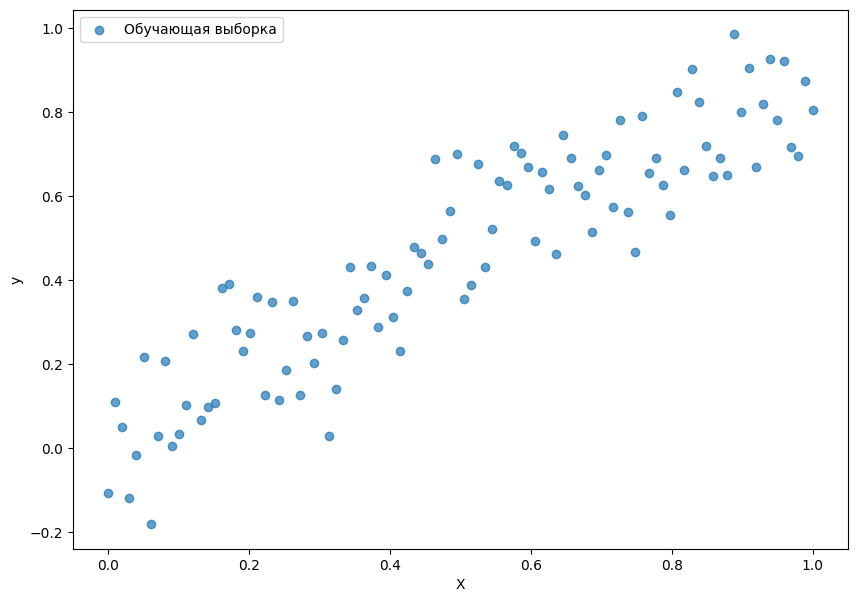

In [9]:
# Функция для визуализации выборки и предсказаний
def plot_sample_model(X, y, plot_predictions = False, y_pred = None, y_pred_label = None, loss = 'mse'):
    plt.figure(figsize = (10, 7))
    plt.scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
    if plot_predictions:
        plt.plot(X, y_pred, label = y_pred_label, c = 'r')
        if loss == 'mse':
            plt.title('MSE: ' + str(mean_squared_error(y, y_pred)))
        elif loss == 'mae':
            plt.title('MAE: ' + str(mean_absolute_error(y, y_pred)))
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend();
    
plot_sample_model(X, y, plot_predictions = False)

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [10]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

In [11]:
from sklearn.tree import DecisionTreeRegressor

# TODO: обучите решающее дерево глубины 1 и сделайте предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# TODO: включите предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

In [12]:
dt1

DecisionTreeRegressor(max_depth=1)

In [13]:
dt1_pred

array([0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.19432774, 0.19432774,
       0.19432774, 0.19432774, 0.19432774, 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 ,
       0.6639547 , 0.6639547 , 0.6639547 , 0.6639547 , 0.66395

In [14]:
pd.DataFrame([dt1_pred]).T[0].unique()

array([0.19432774, 0.6639547 ])

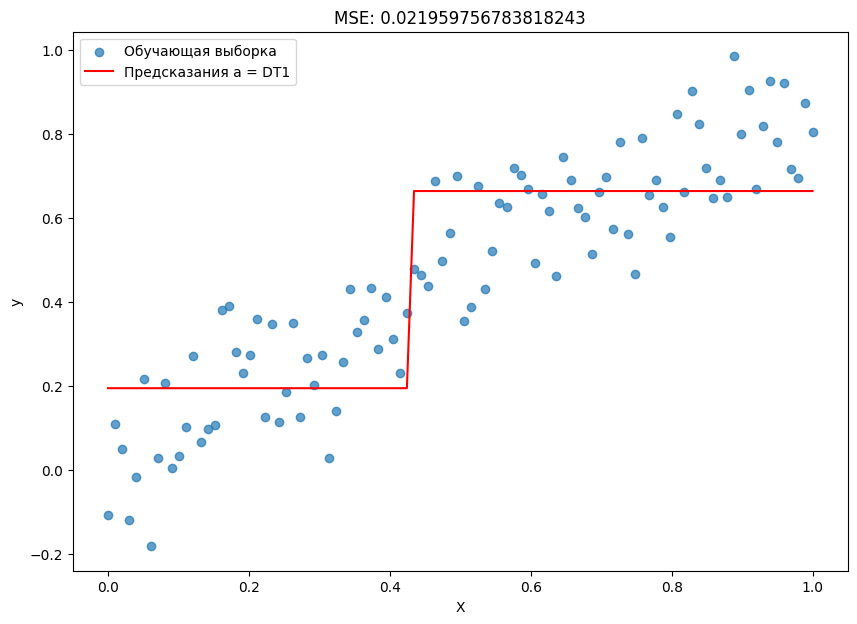

In [15]:
# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В качестве ошибок композиции будем использовать **остатки** – 
расстояния от предсказаний композиции до истинных ответов:

$$
s^{(1)}(X) = y - a^{(1)}(X)
$$

Заметим, что $MSE$ – это усреднённая сумма квадратов остатков и что остатки являются естественным выражением ошибки: если мы прибавим остатки к ответам модели, то добьёмся нулевой среднеквадратичной ошибки. Таким образом, логично строить следующую модель так, чтобы она хорошо предсказывала остатки композиции: если мы прибавим предсказания второй модели (предсказанные остатки) к предскзазаниям первой, то добьёмся снижения ошибки.

In [16]:
# TODO: рассчитайте остатки  
s1 = y - a

In [17]:
s1

array([-0.3028908 , -0.08449236, -0.14582925, -0.31465882, -0.21179472,
        0.02129949, -0.3764267 , -0.16657084,  0.01298605, -0.19021786,
       -0.16137794, -0.09291601,  0.07572674, -0.12728186, -0.09778266,
       -0.08682677,  0.18717878,  0.19522538,  0.08689573,  0.0350341 ,
        0.08005797,  0.1652795 , -0.06751339,  0.15349412, -0.07965913,
       -0.00825298,  0.15600043, -0.06783691,  0.07073806,  0.00825474,
        0.07852412, -0.16614746, -0.05384791,  0.06287923,  0.23514136,
        0.13452536,  0.16163201,  0.23959188,  0.09220092,  0.21786403,
        0.11827222,  0.03530938,  0.17821276, -0.18575923, -0.20013943,
       -0.22608378,  0.0233886 , -0.16554962, -0.10000679,  0.03484684,
       -0.30951159, -0.27516682,  0.01184803, -0.23361583, -0.14217965,
       -0.02960772, -0.03891383,  0.0560043 ,  0.0385247 ,  0.00428775,
       -0.17159147, -0.00656153, -0.04640675, -0.20230646,  0.08014339,
        0.02716909, -0.04103589, -0.06098753, -0.14966576, -0.00

**Шаг 3.** Обучим второе решающее дерево $DT_2$, предсказывающее остатки. Добавим предсказания второго дерева в композицию: $a^{(2)}(X) = DT_1 + DT_2$. Получим предсказания композиции на обучающей выборке.

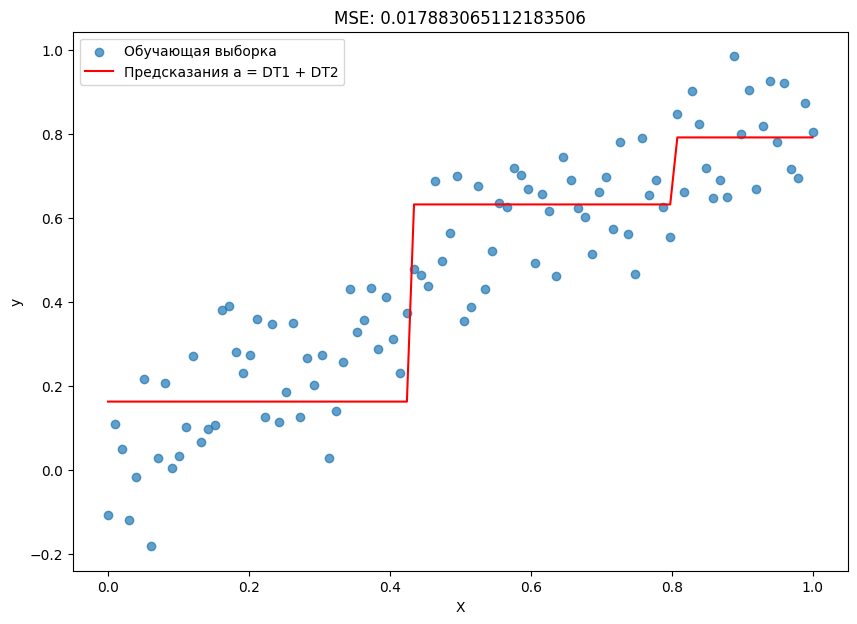

In [18]:
# TODO: обучите второе решающее дерево глубины 1, предсказывающее остатки
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# TODO: сделайте предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# TODO: включите предсказания второго дерева в композицию (простым суммированием)
a += dt2_pred #~ a = a + dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

Как мы видим, решающая поверхность стала более сложной, и теперь она более точно приближает обучающую выборку. 

**Шаги 4 – ...** Повторяем шаги 2-3, пока не надоест.

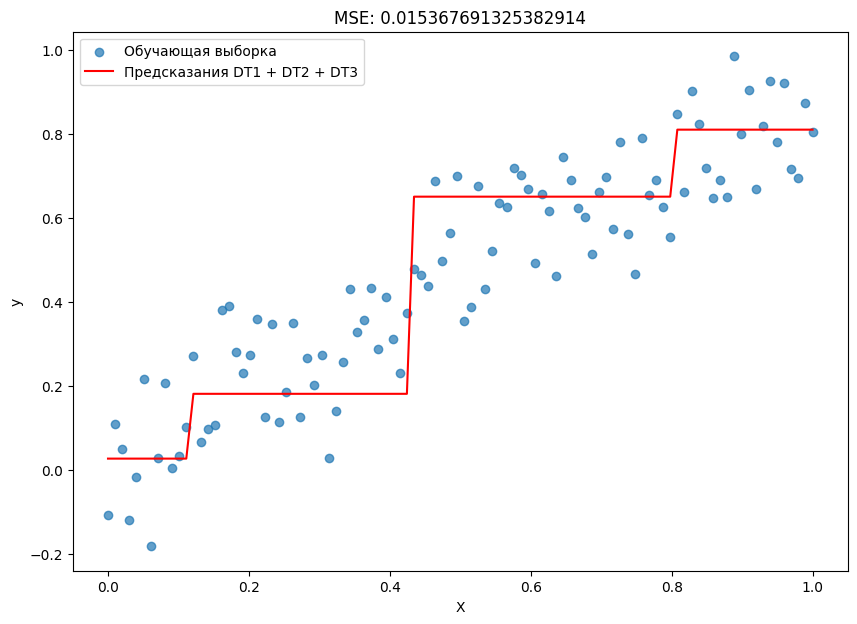

In [19]:
# TODO: рассчитайте остатки
s2 = y - a

# TODO: обучите третье решающее дерево глубины 1, предсказывающее остатки
dt3 = DecisionTreeRegressor(max_depth = 1)
dt3.fit(X, s2)

# TODO: сделайте предсказания на обучающей выборке
dt3_pred = dt3.predict(X)

# TODO: включите предсказания третьего дерева в композицию (простым суммированием)
a += dt3_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания DT1 + DT2 + DT3')

Как мы видим, при добавлении базовых моделей решающая поверхность становится более сложной и всё точнее приближает обучающую выборку.

**Важный момент:** заметим, что при обучении очередной базовой модели композиция предыдущего шага считается фиксированной. Это означает, что обучение новой базовой модели не влияет на уже обученные модели, содержащиеся в композиции.

#### 1.2 Бустинг над разными моделями.

При помощи функции `plot_boosting_results()` можно визуализировать решающие поверхности композиции, очередной базовой модели и остатки при добавлении базовых моделей. 

**Задание:** посмотрите, как выглядят решающие поверхности композиции, если в качестве базовой модели использовать
- решающее дерево
- линейную регрессию
- `kNN`-регрессор
- `SVR`.

In [20]:
def plot_boosting_results(base_estimator, n_estimators, X, y):
    fig, ax = plt.subplots(n_estimators, 3, figsize = (20, n_estimators * 5))
    # Остатки
    resid = []
    resid.append(y)
    # Предсказания моделей
    y_pred = []
    for i in range(n_estimators):
        # Обучение очередной базовой модели
        base_estimator.fit(X, resid[-1]) 
        # Предсказание базовой модели
        y_pred.append(base_estimator.predict(X))
        # Вычисление предсказания композиции
        a = np.sum(y_pred, axis = 0)
        # Вычисление остатка
        resid.append(y - a)
        # Предсказания композиции
        ax[i, 0].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 0].plot(X, a, c = 'red', lw = 3, label = 'n_estimators: ' + str(i + 1))
        ax[i, 0].set_title('MSE: ' + str(mean_squared_error(y, a)))
        # Предсказания очередной модели
        ax[i, 1].scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
        ax[i, 1].plot(X, y_pred[-1], c = 'red', lw = 3)
        ax[i, 1].set_title('Предсказания модели ' + str(i + 1))
        ax[i, 2].scatter(X, resid[-1], alpha = 0.7, marker = 'v', c = 'orange')
        ax[i, 2].set_title('Остатки')
        ax[i, 0].legend()

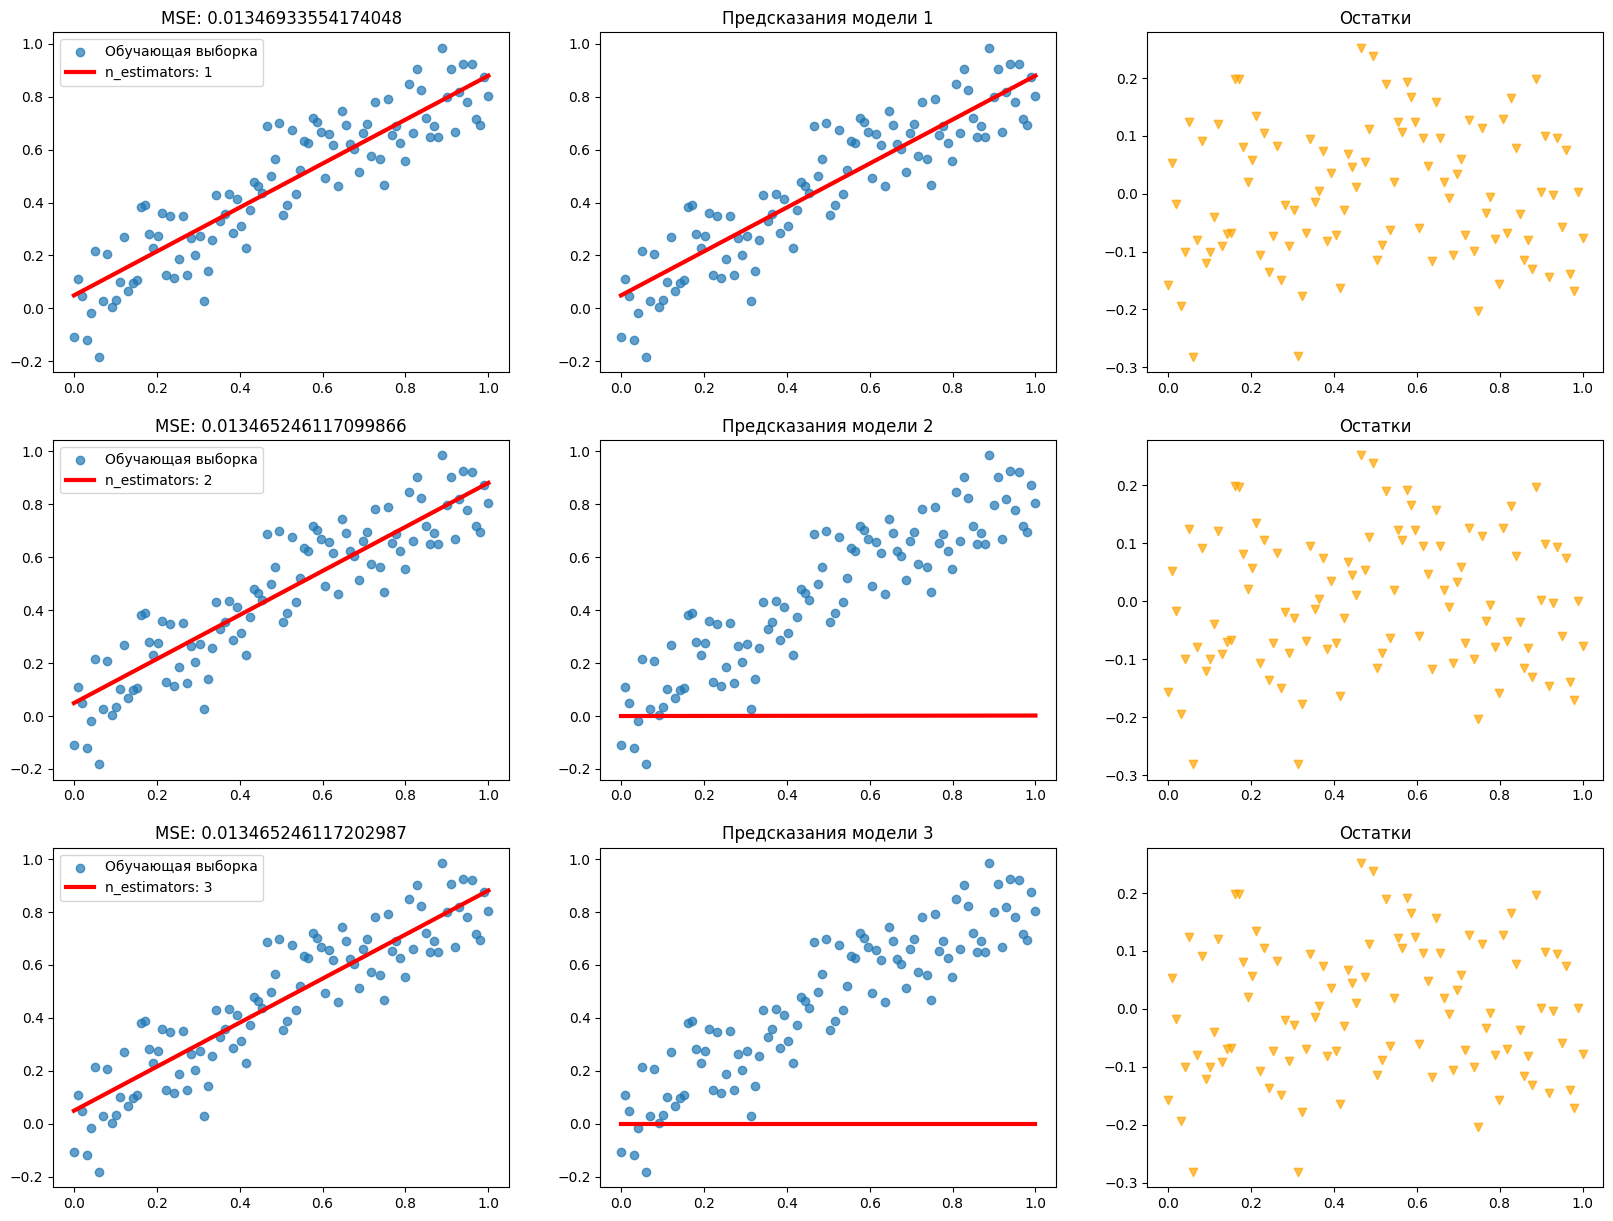

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

plot_boosting_results(SVR(kernel = 'linear'), n_estimators = 3, X = X, y = y)

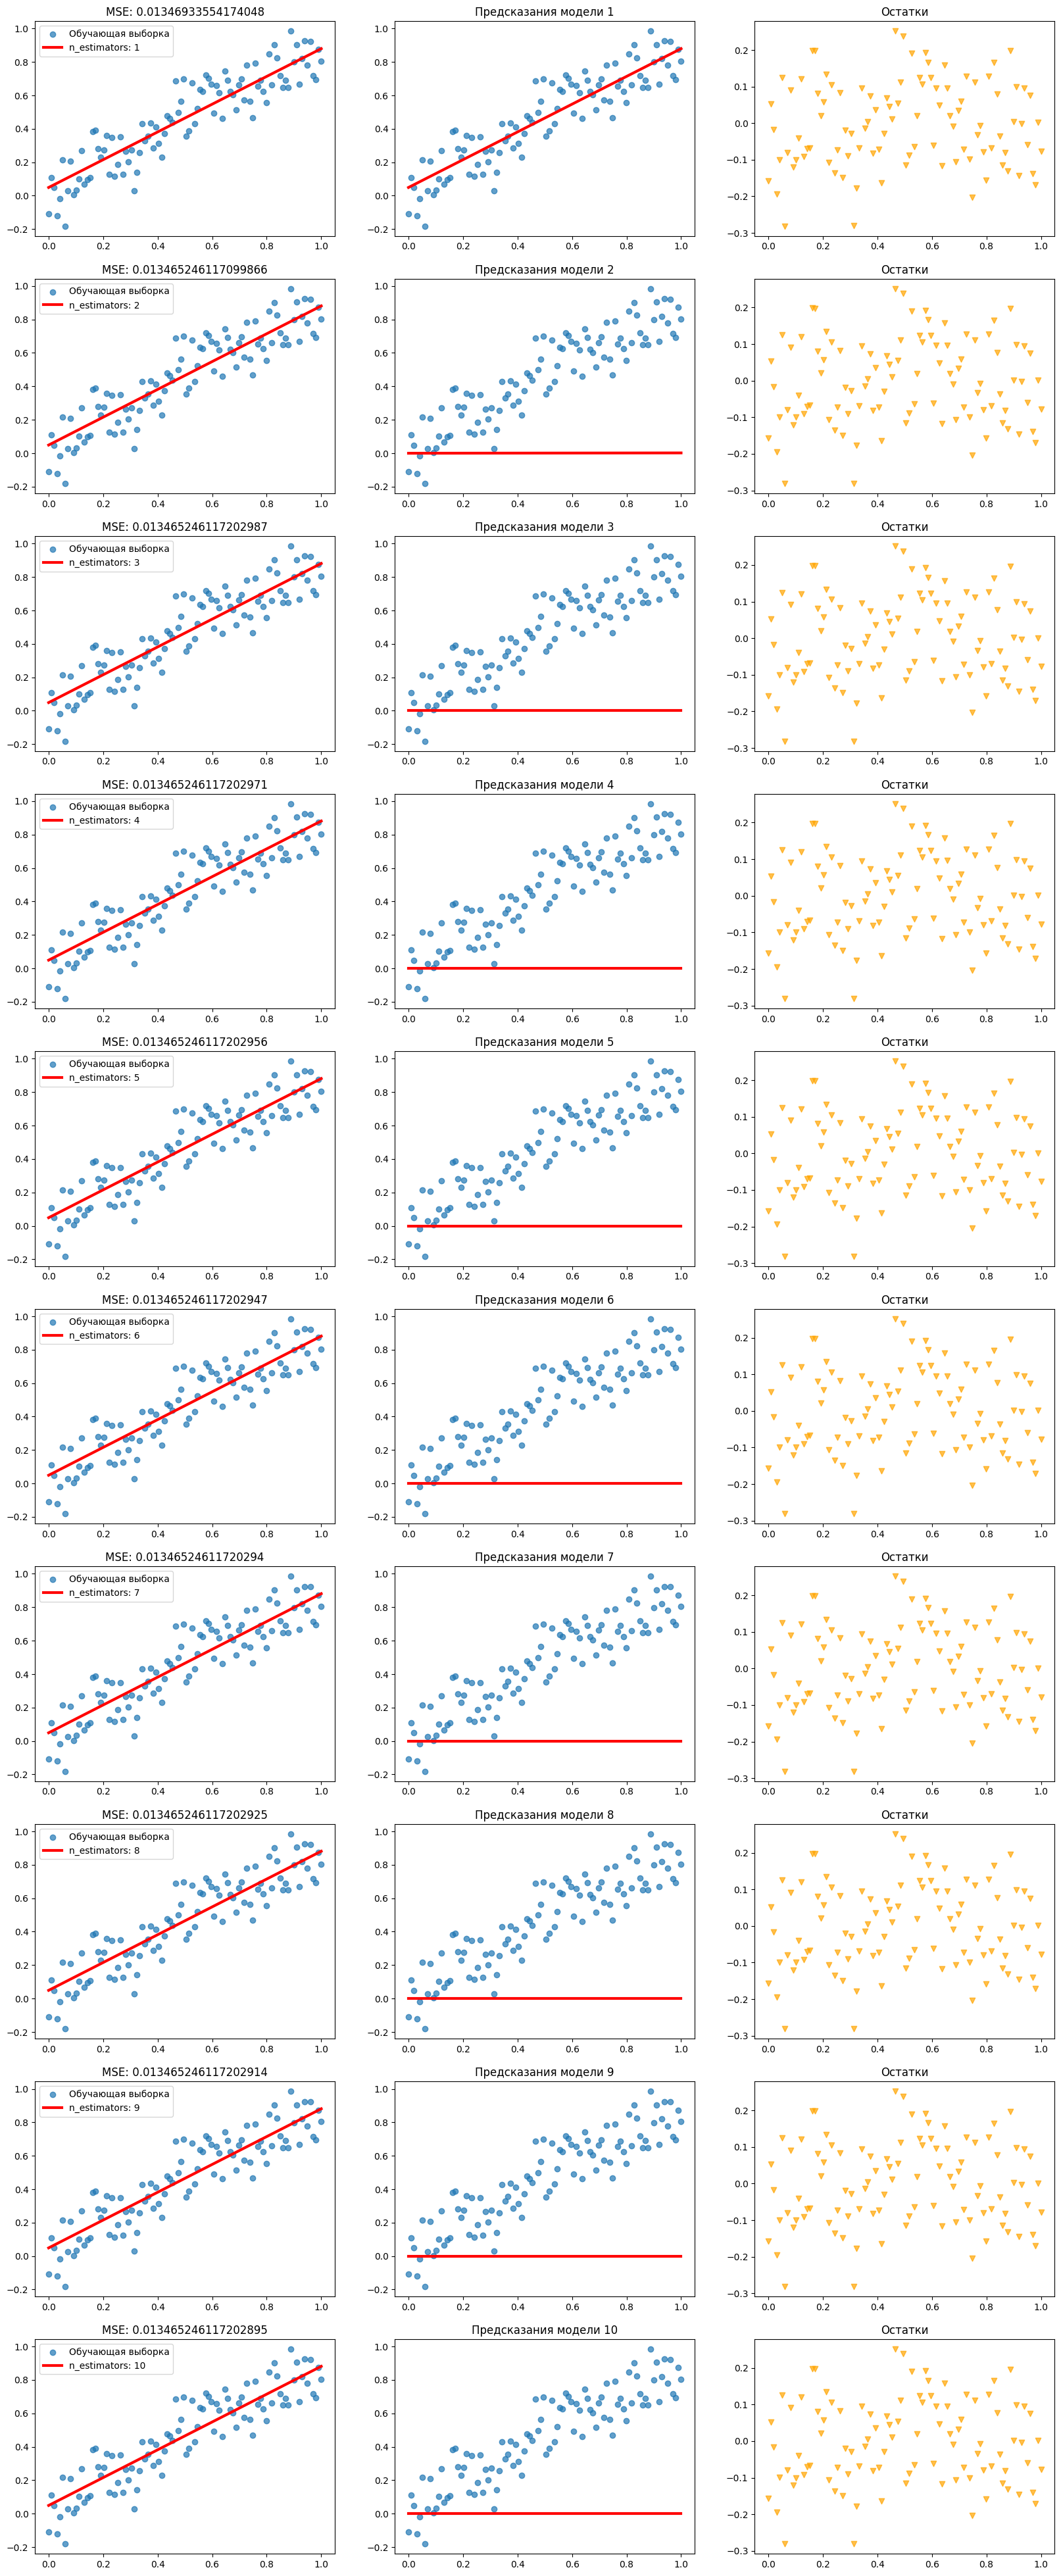

In [22]:
plot_boosting_results(SVR(kernel = 'linear'), n_estimators = 10, X = X, y = y)

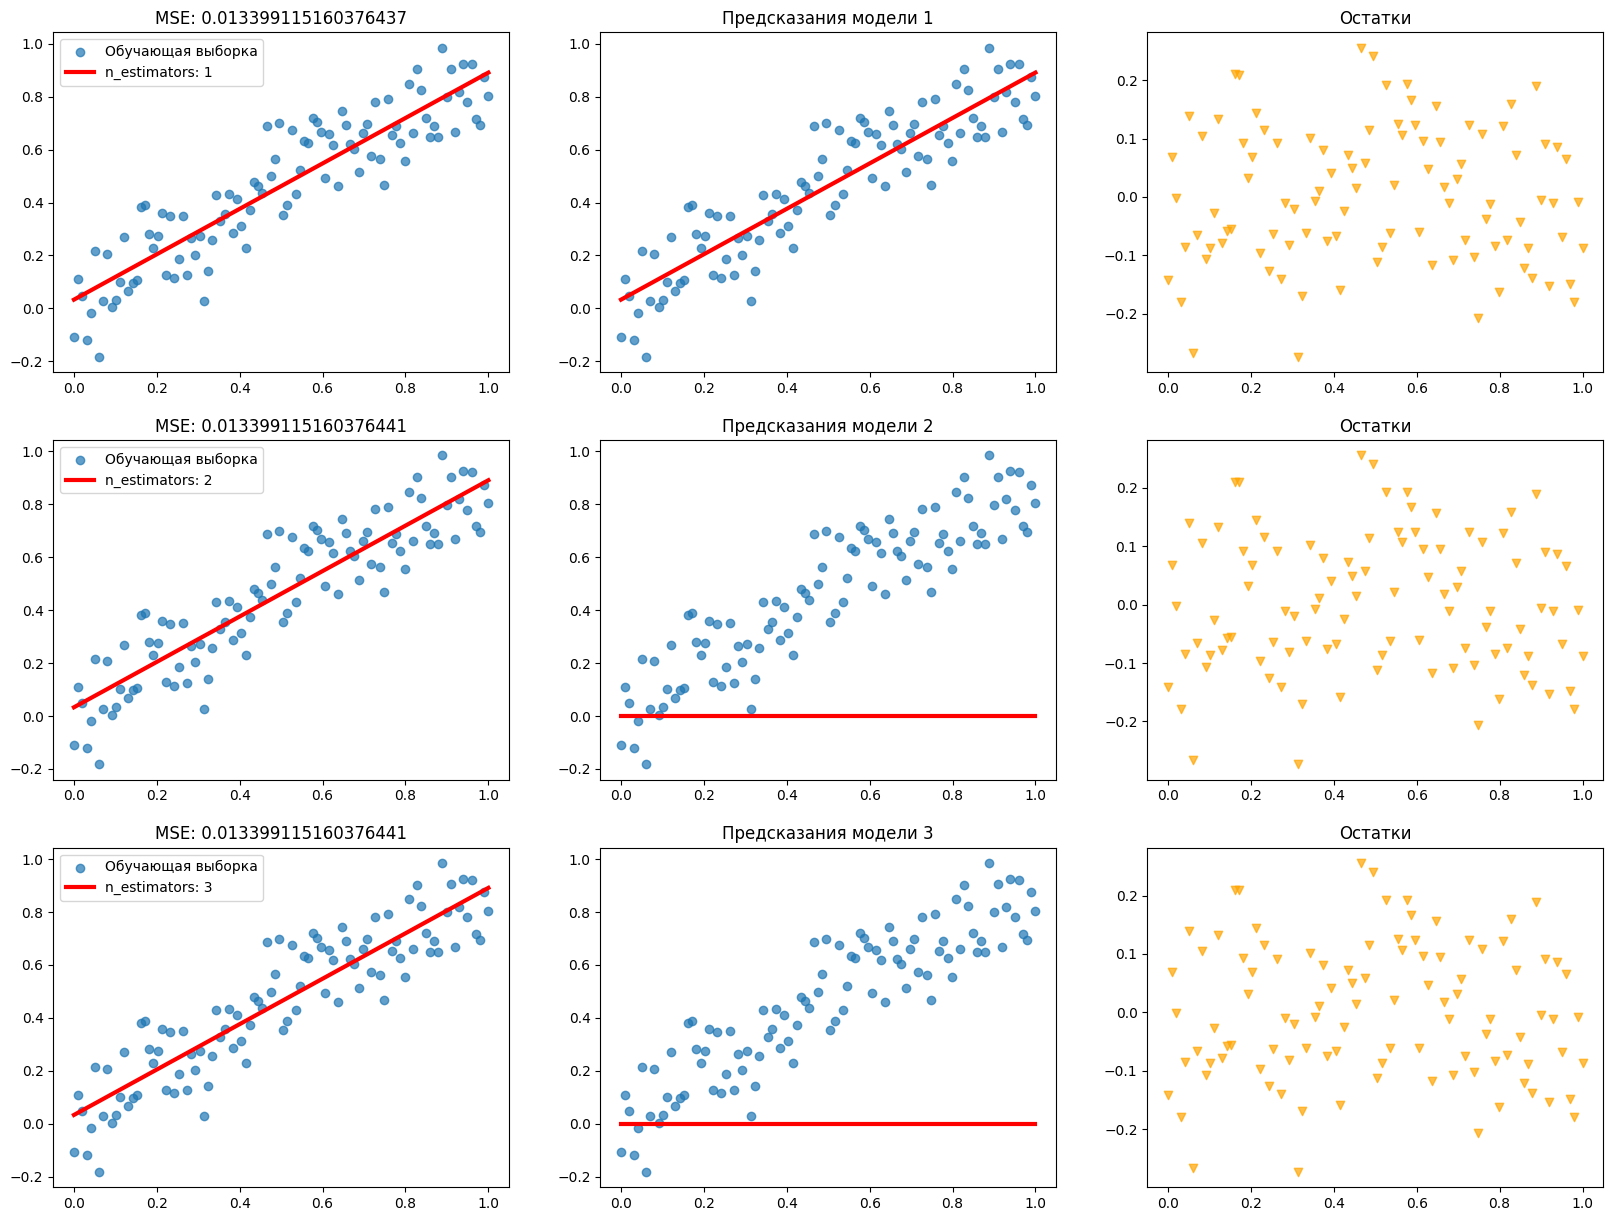

In [23]:
plot_boosting_results(LinearRegression(), n_estimators = 3, X = X, y = y)

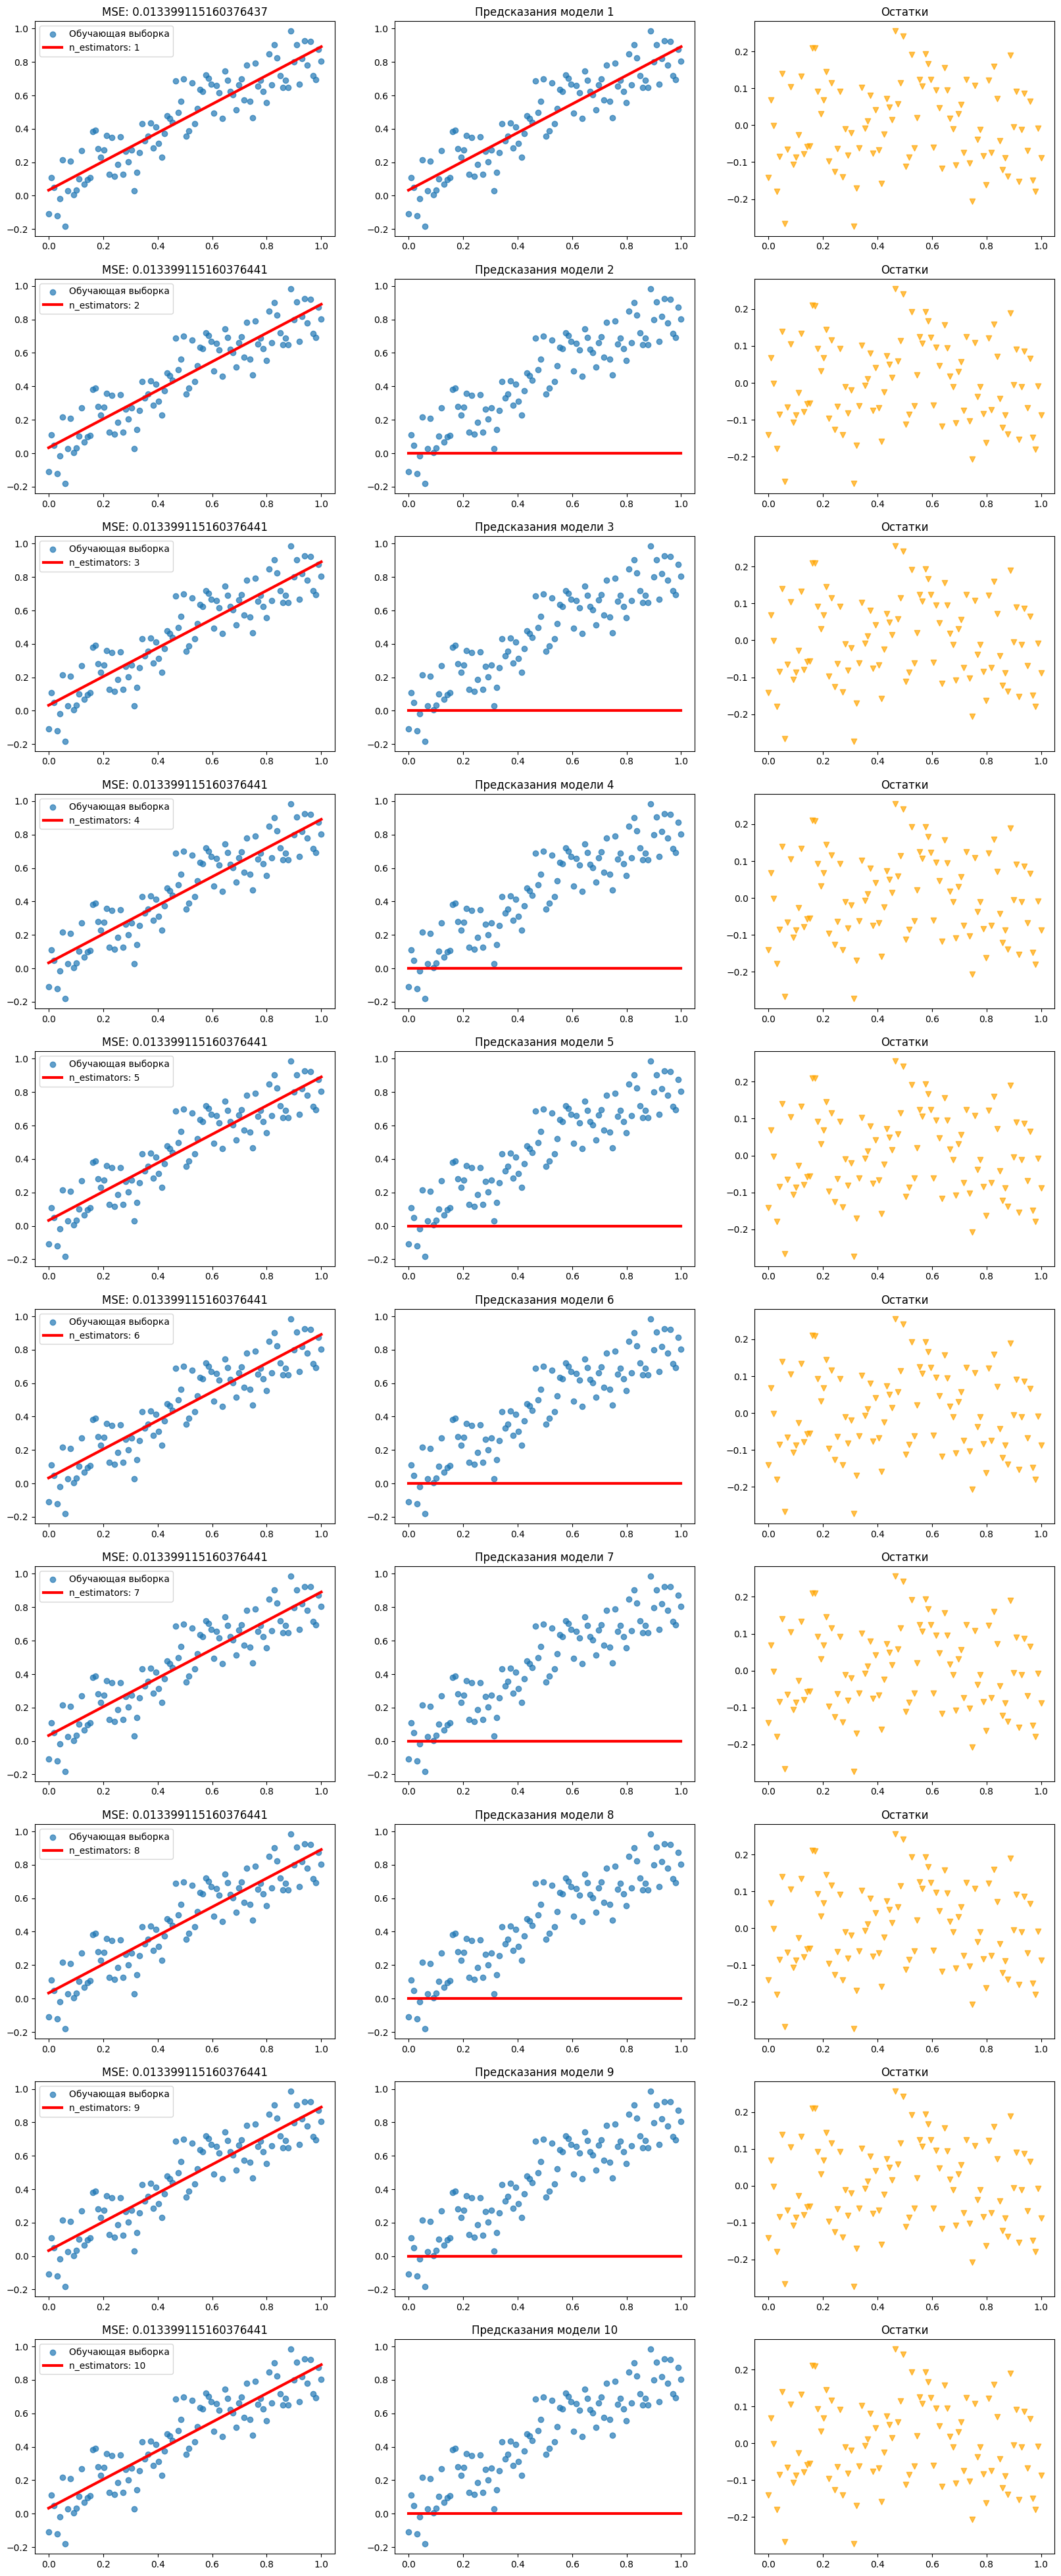

In [24]:
plot_boosting_results(LinearRegression(), n_estimators = 10, X = X, y = y)

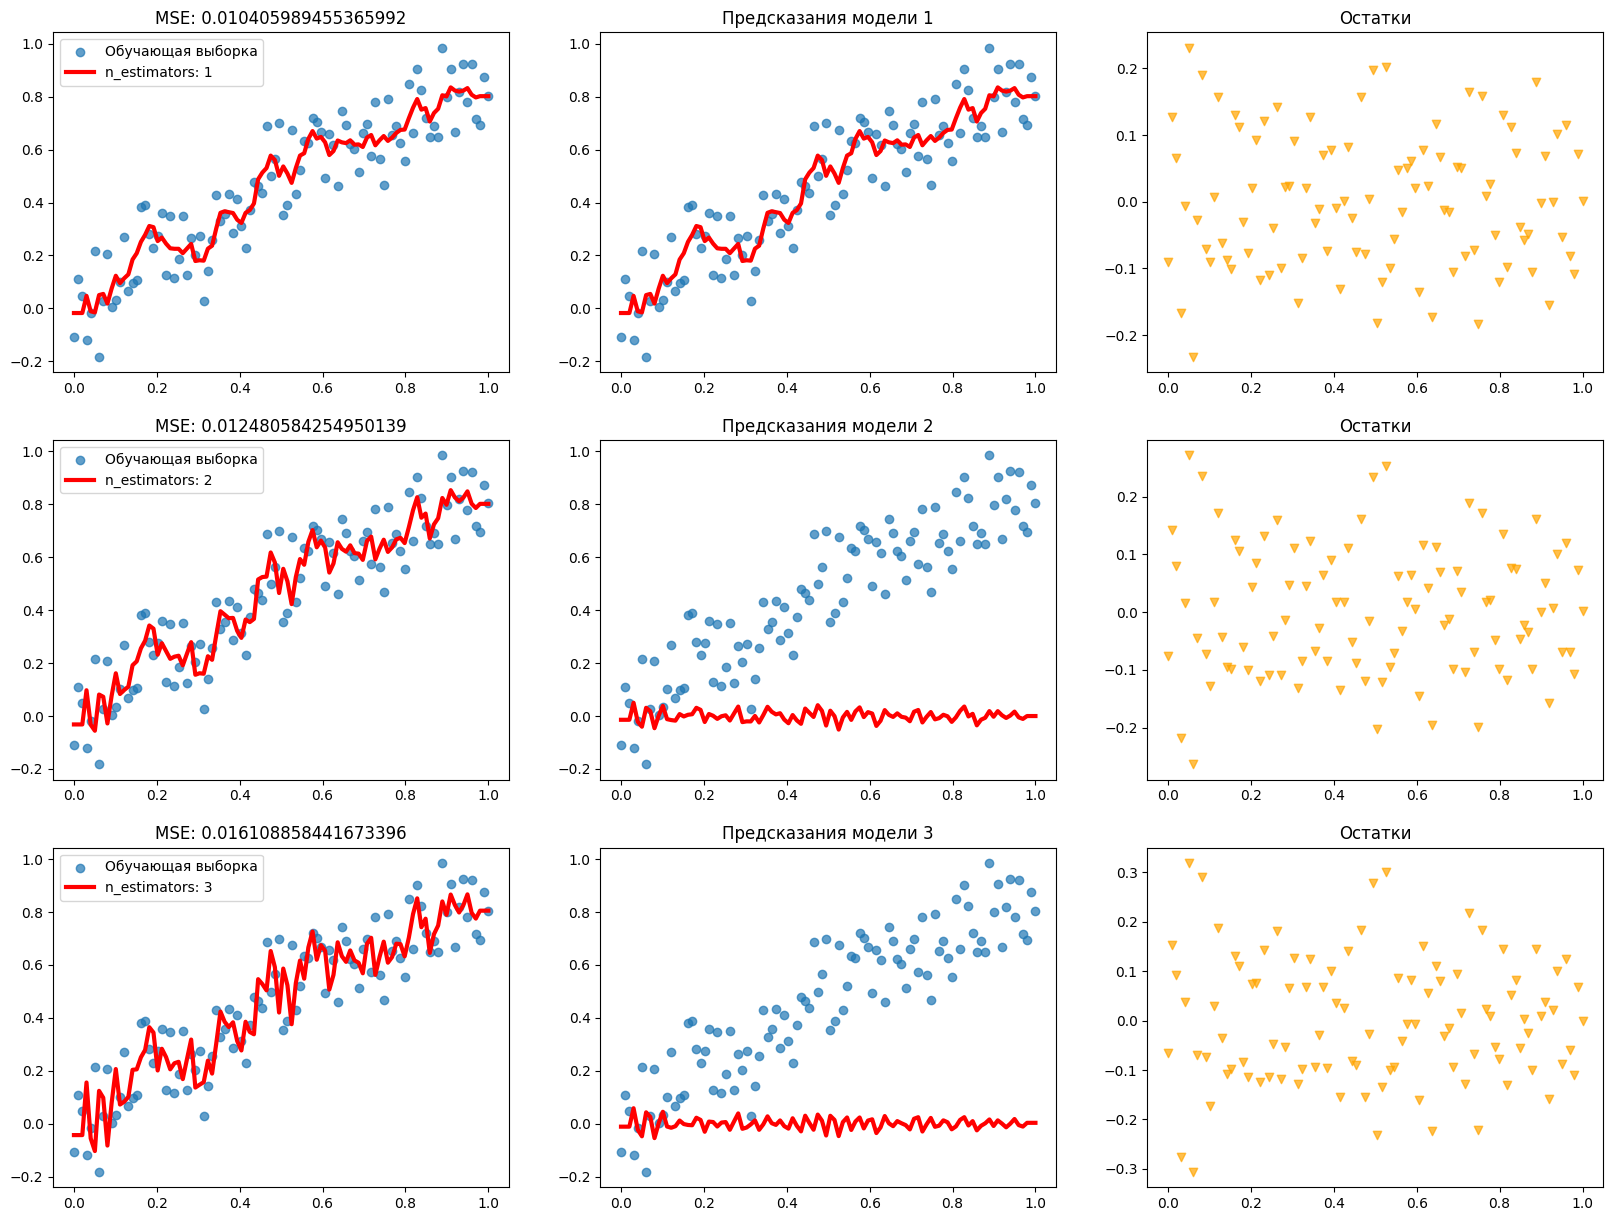

In [25]:
plot_boosting_results(KNeighborsRegressor(), n_estimators = 3, X = X, y = y)

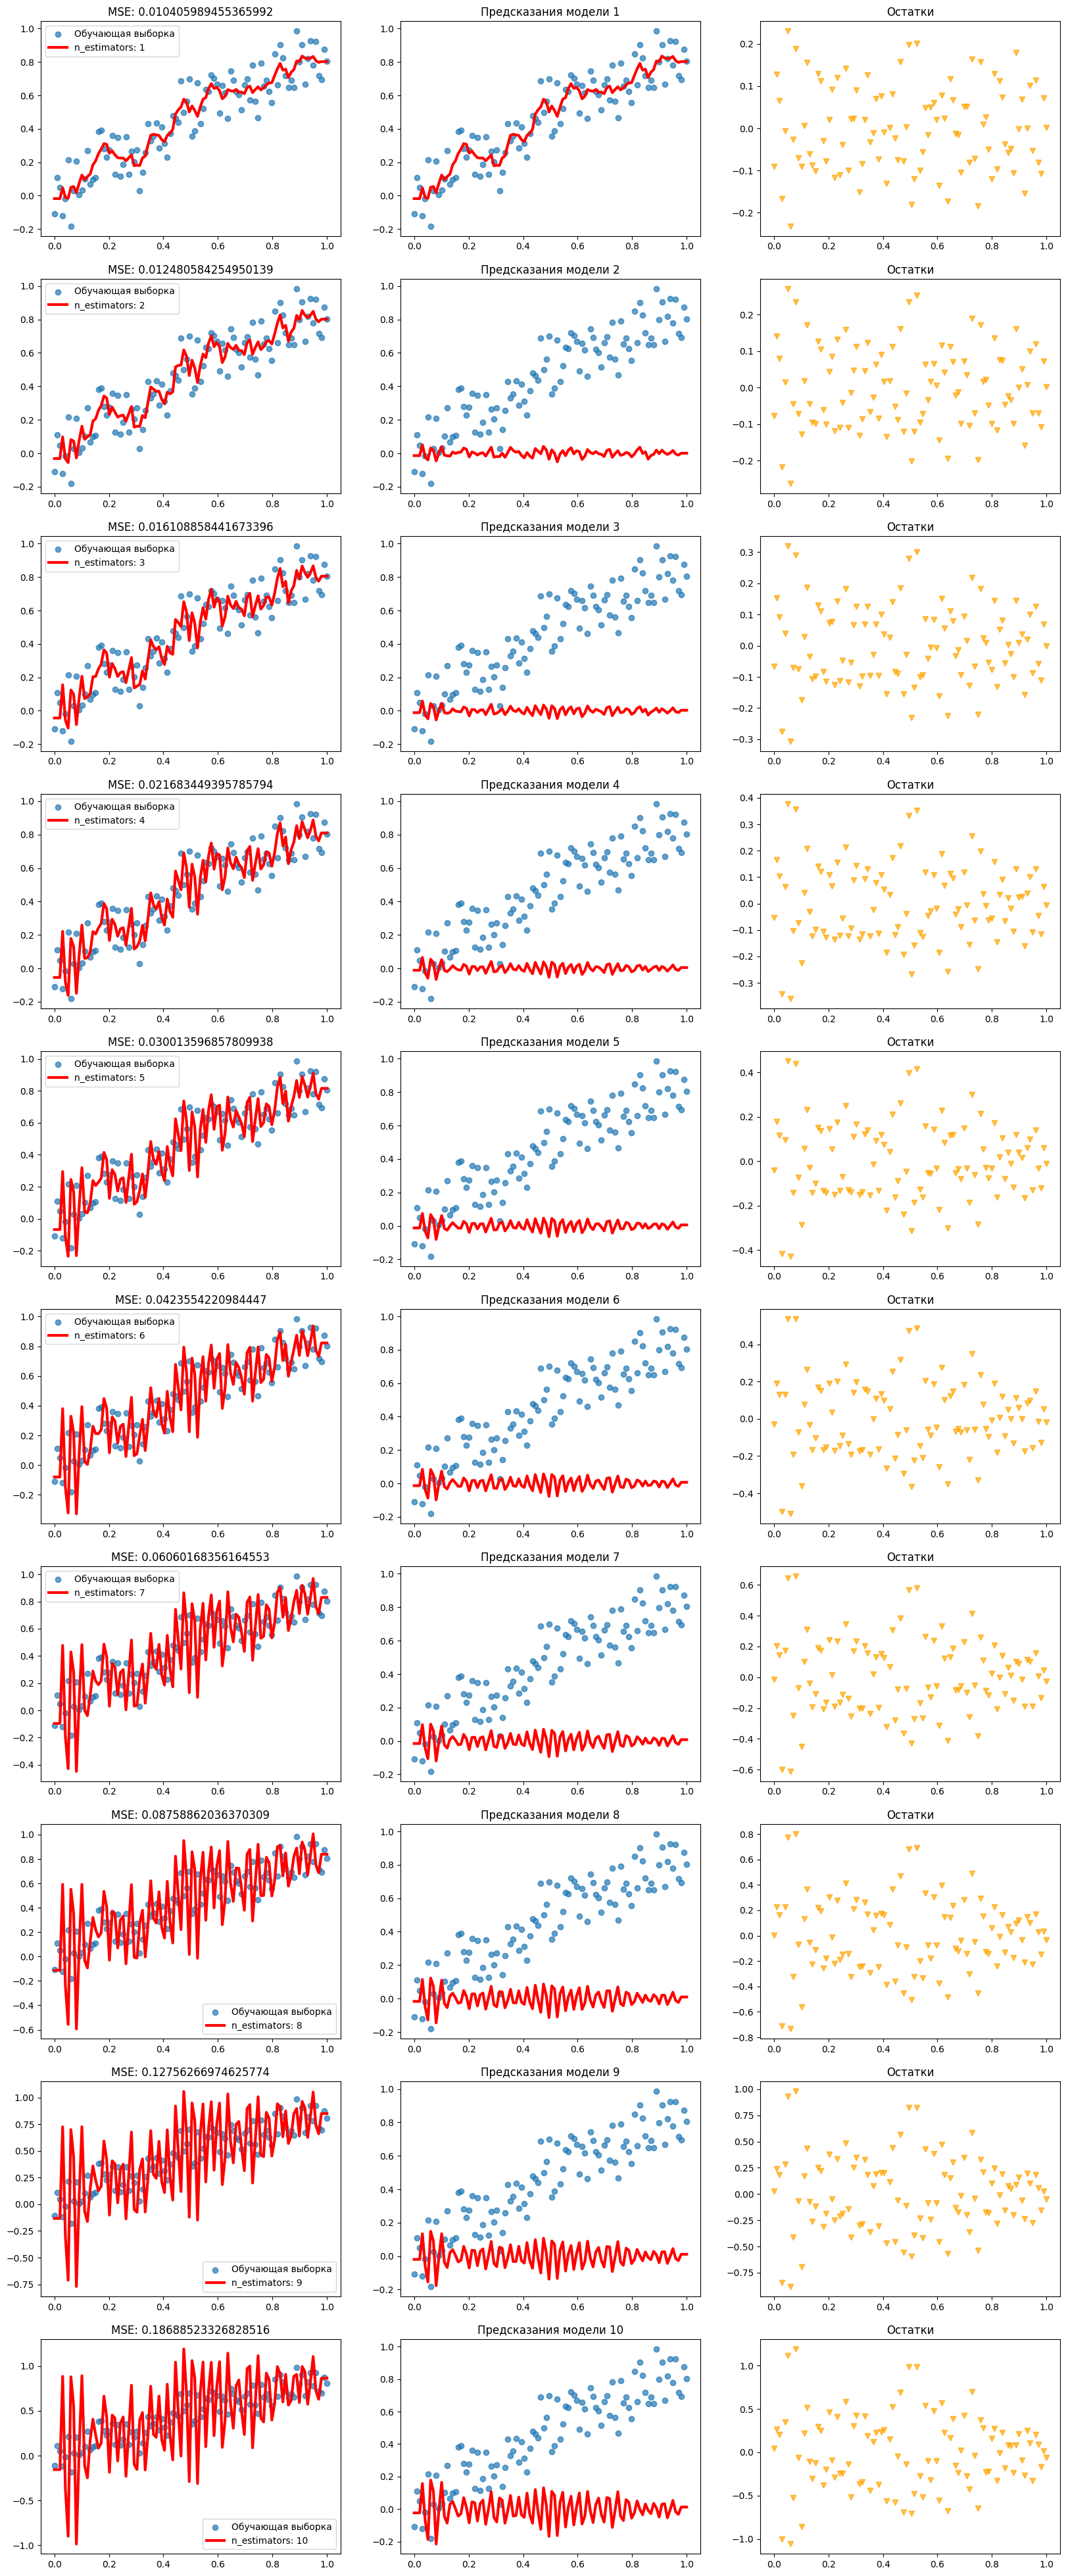

In [26]:
plot_boosting_results(KNeighborsRegressor(), n_estimators = 10, X = X, y = y)

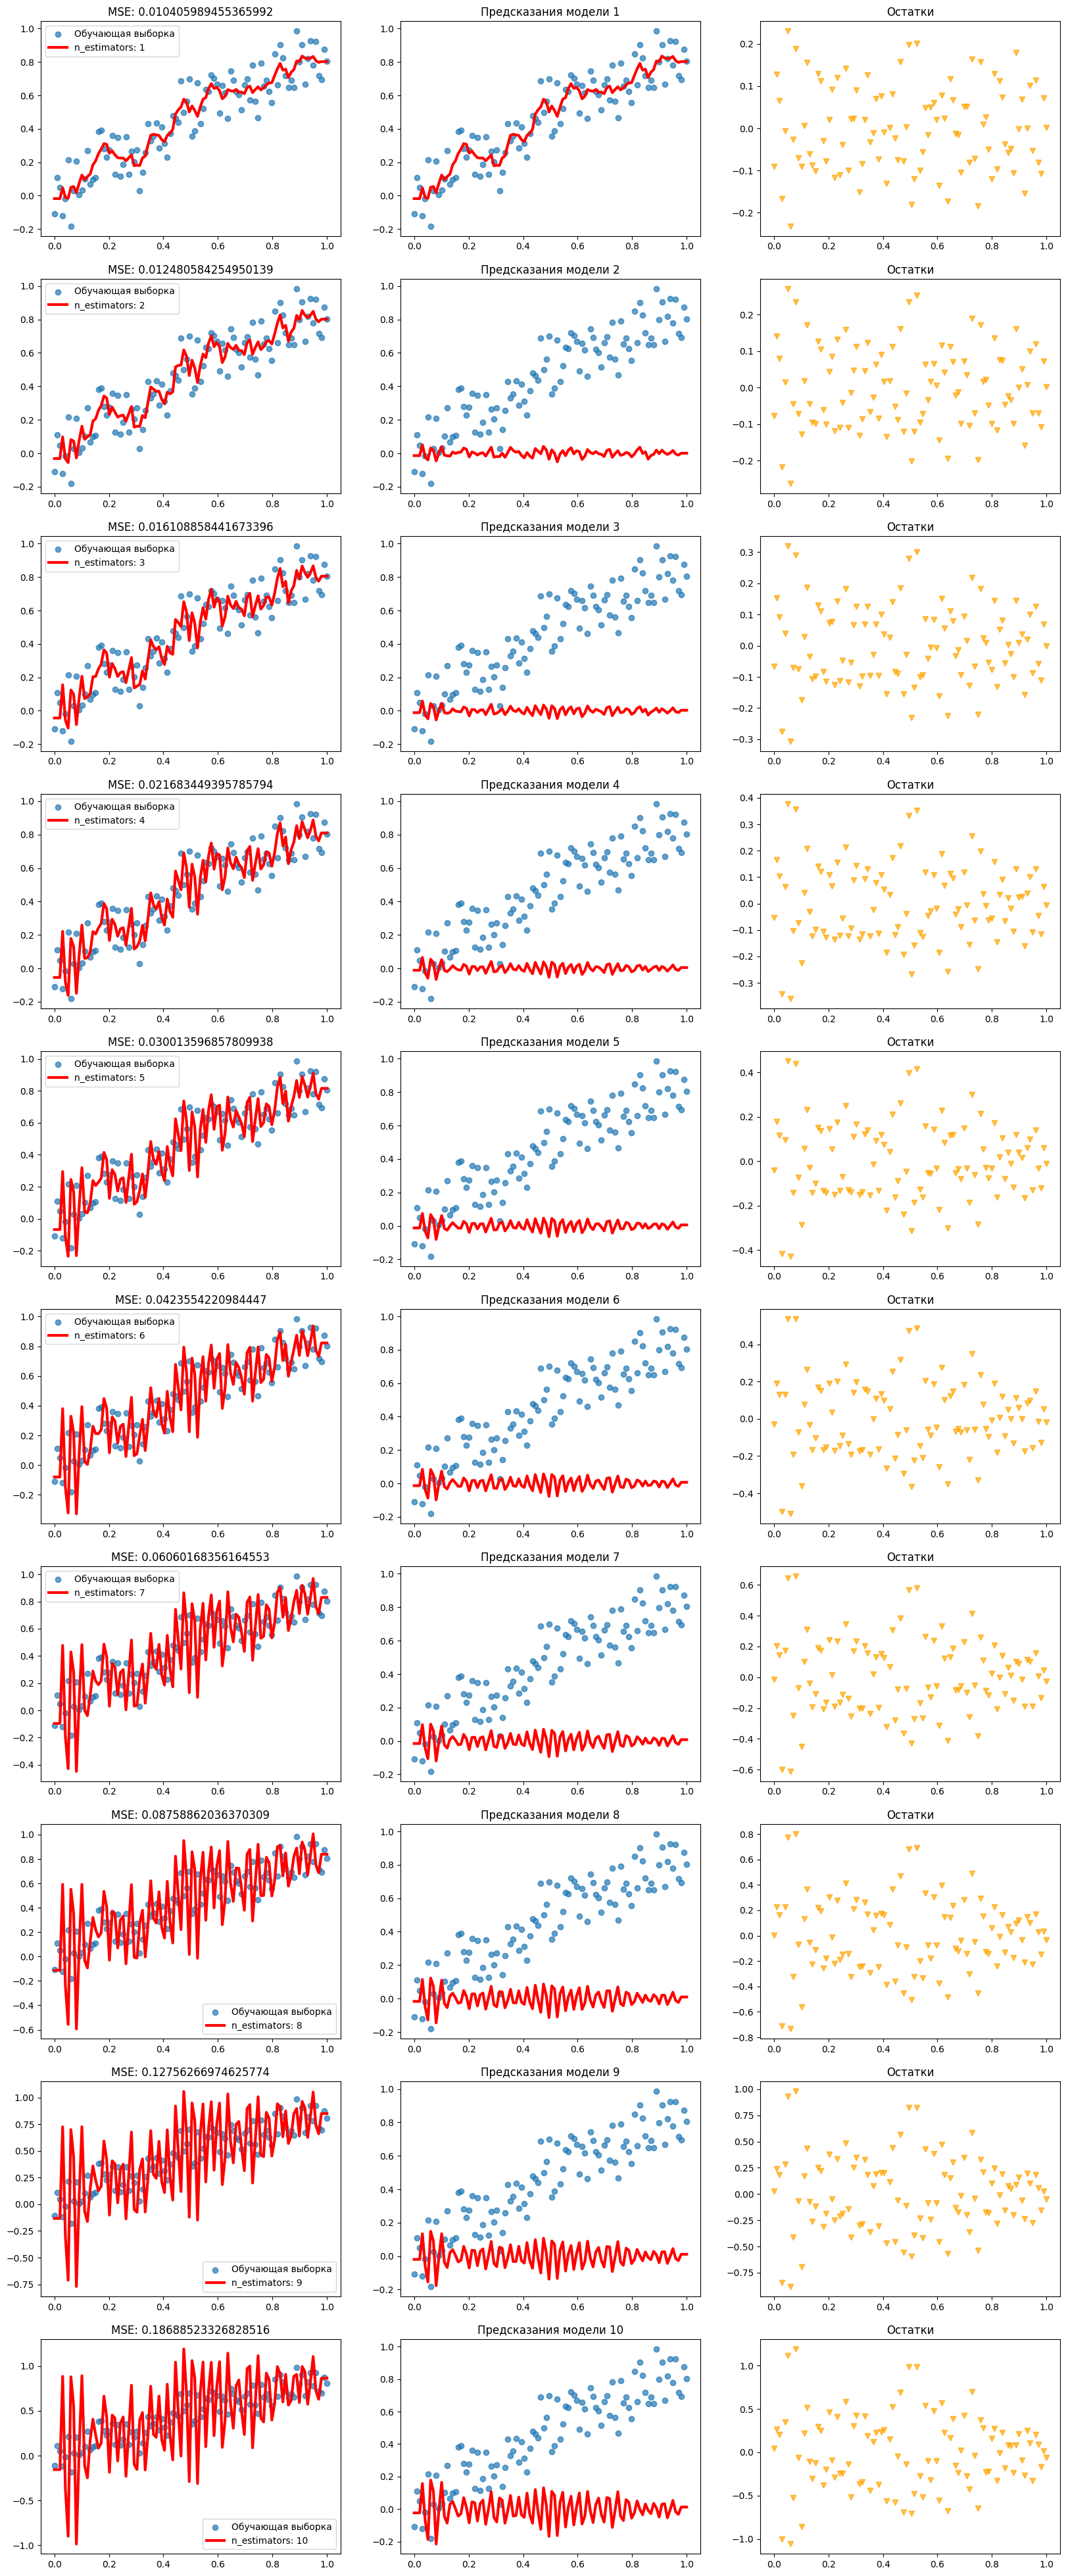

In [27]:
plot_boosting_results(KNeighborsRegressor(), n_estimators = 10, X = X, y = y)

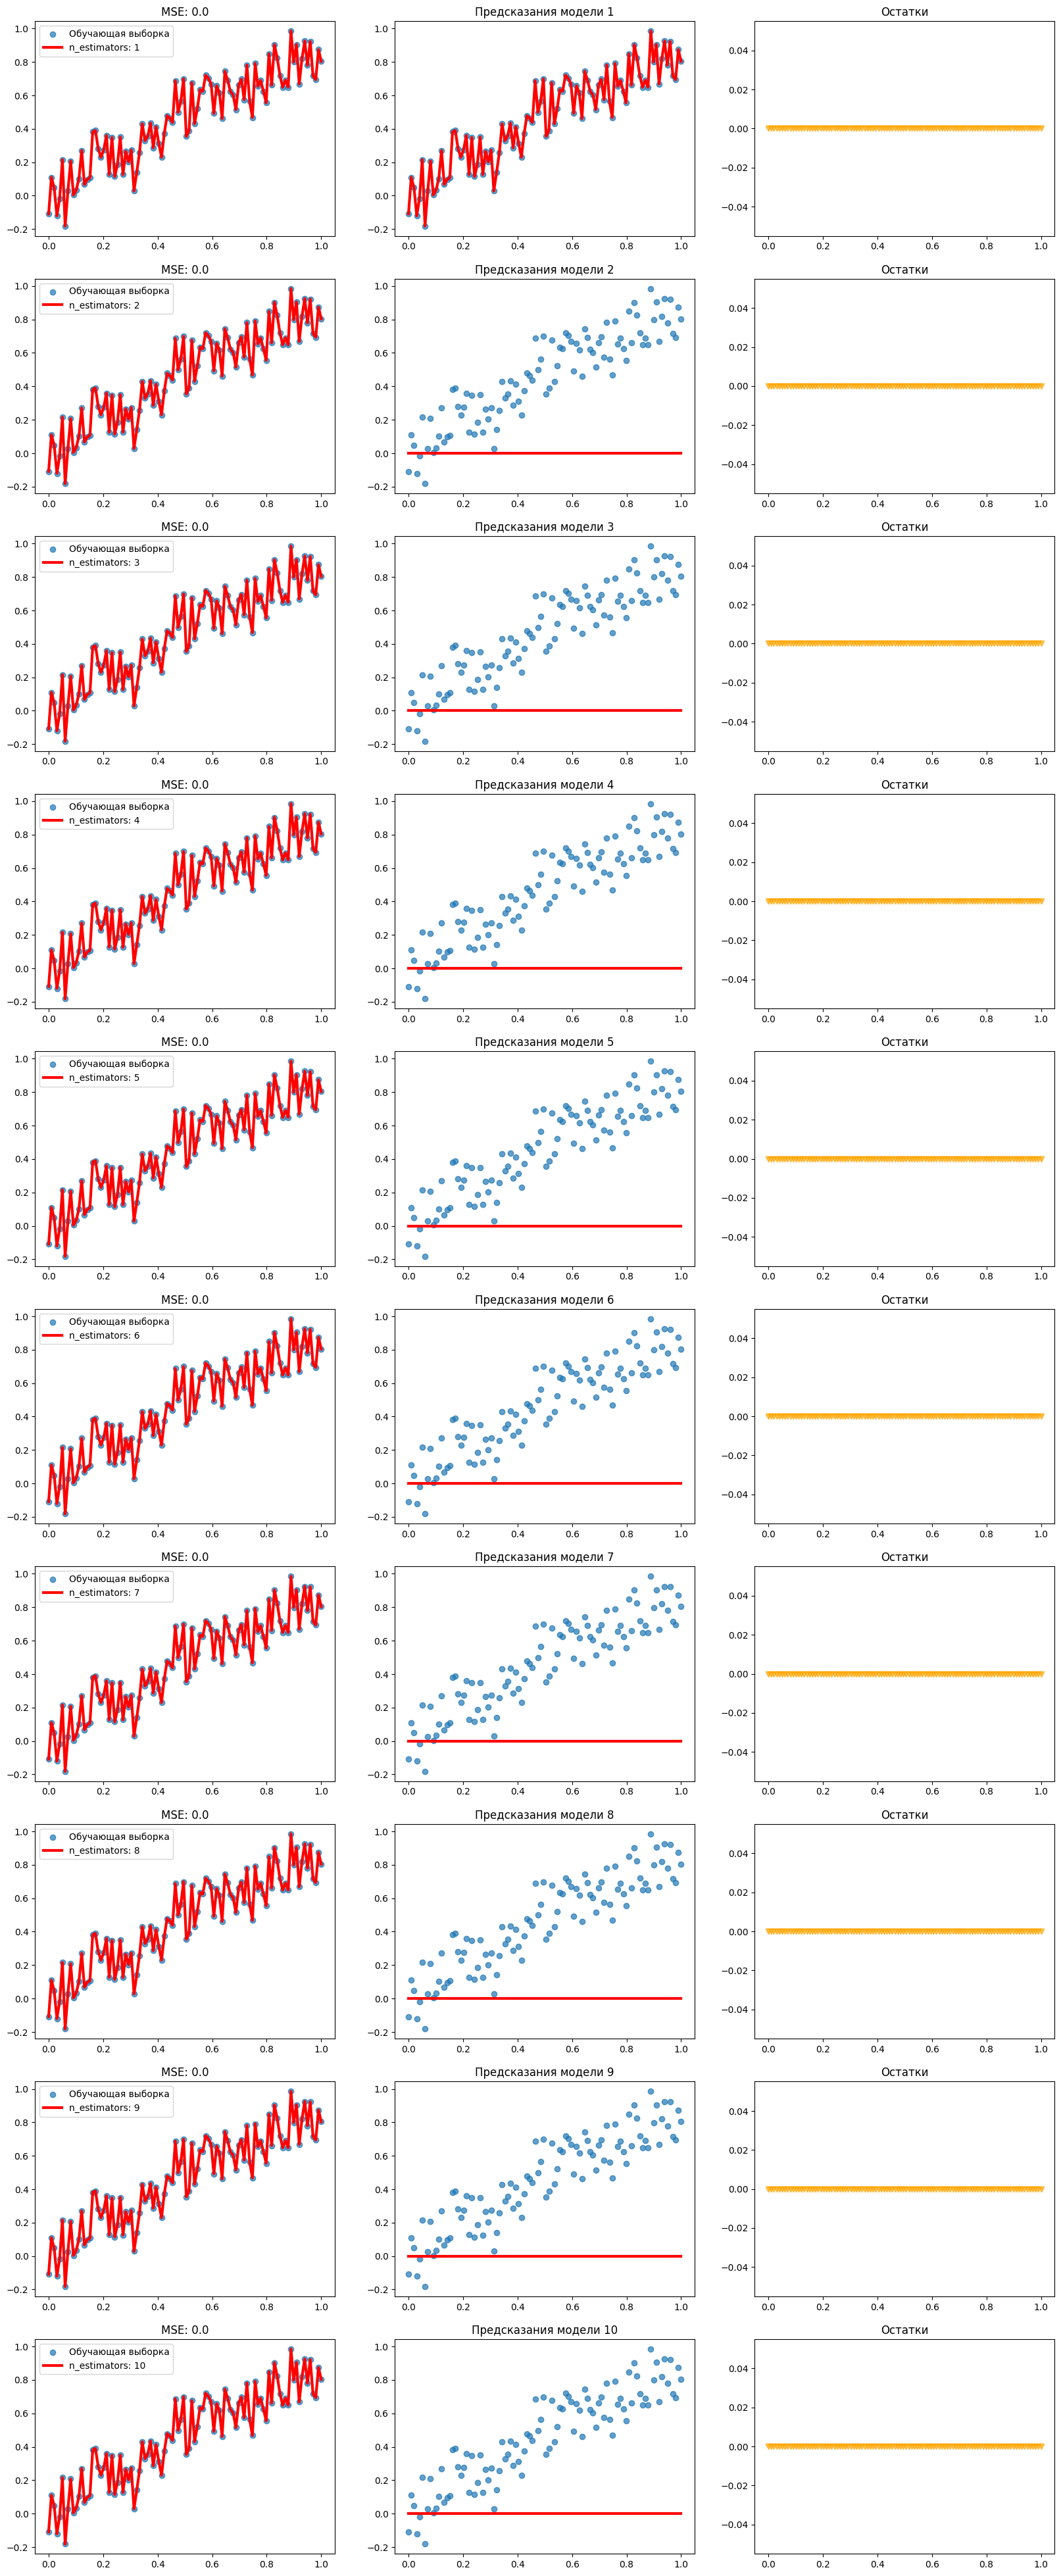

In [28]:
plot_boosting_results(DecisionTreeRegressor(), n_estimators = 10, X = X, y = y)

### 2. Градиентный бустинг

Заметим, что в примере выше использование остатков как меры ошибки модели было оправданным, так как остатки непосредственно участвуют в расчёте $MSE$. Попробуем обобщить идею использования остатков на произвольную функцию потерь.

Будем решать ту же задачу, что и выше, но с использованием произвольной функции потерь $L(\cdot)$. Предположим, что каким-то образом мы уже обучили $N$ базовых моделей и построили композицию $a^{(N)}(X)$. Как построить $(N+1)$-ю базовую модель?

Заметим, что мы хотим выбрать $(N+1)$-ую базовую модель так, чтобы как можно сильнее уменьшить ошибку:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + b^{(N+1)}(x_i)] \to \min_{b^{(N+1)}},
$$

где $b^{(N+1)}(x_i)$ – предсказания новой базовой модели. Теперь заметим, что так как и $y_i$, и $a^{N}(x_i)$ фиксированы (обсуждали выше), то в сущности нам нужно найти числа $b^{(N+1)}(x_i) = s_i^{(N)}$, которые сильнее всего уменьшили бы функцию потерь:


$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} L[y_i, a^{N}(x_i) + s^{(N)}_i] \to \min_{s^{(N)}_i}.
$$

**Замечание.** Заметьте, что теперь мы ищем просто числа $s^{(N)}_i$, которые сильнее всего уменьшили бы функцию.

После изучения градиентного спуска мы знаем, что вектор чисел, сильнее всего уменьшающих какую-то функцию – это антиградиент этой функции. Таким образом, в качестве чисел $s_i^{(N)}$ следует взять

$$
s_i^{(N)} = -\dfrac{\partial L(y, p)}{\partial p}
$$

в точке $p = a^{(N)}(x_i)$, то есть антиградиент функции потерь в точке ответов уже построенной композиции. 

**Чек-пойнт.** Убедитесь, что вы понимаете, какие **числа**, нужно взять, чтобы решить задачу. 

Итак, мы выяснили, какие числа нужно взять для уменьшения функции потерь на **обучающей выборке**. Вспомним, что мы определяли эти числа как $b^{(N+1)}(x_i) = s_i^{(N)}$, то есть ответы очередной базовой модели. Таким образом, нам нужно обучить очередную базовую модель так, чтобы она хорошо приближала антиградиент функции потерь в точке ответов уже построенной композиции – а это хорошо известная нам задача обучения с учителем. Обычно она решается путём минимизации $MSE$:

$$
b^{(N+1)}(x) = \arg\min_b \sum_{i = 1}^{\ell} (b(x_i) - s_i^{(N)})^2.
$$

**Важный момент:** заметим, что задача, описанная выше – это не изначальная задача! В этом и состоит магия градиентного бустинга: мы можем использовать любую функцию потерь, через неё вывести $s_i^{(N)}$, а затем просто решать задачу приближения при помощи $MSE$!

#### 2.1 Продолжение простого примера для понимания идеи.

Повторим шаги из примера 1.1, используя градиентный бустинг, чтобы лучше разобраться в идее и провести параллели. Вспомним, что мы решали задачу регрессии при помощи минимизации $MSE$.

Нулевой и первый шаги в этих примерах совпадают.

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [29]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

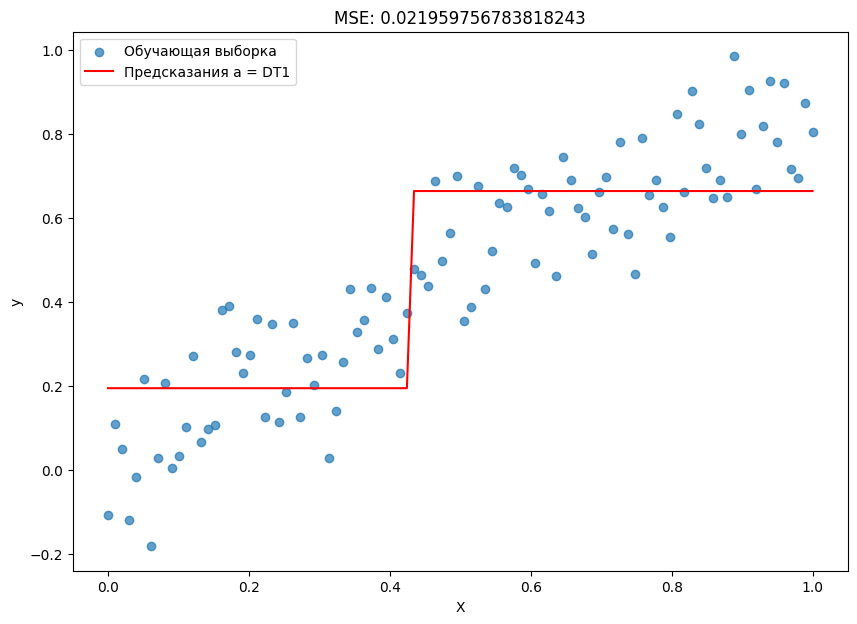

In [30]:
from sklearn.tree import DecisionTreeRegressor

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В примере 1.1 на этом шаге мы рассчитывали остатки. Здесь же мы должны рассчитать антиградиент функции потерь в точке ответов уже построенной композиции.

**Задание:** вычислите градиент $MSE$

$$
L(y, p) = \dfrac{1}{2} \sum_{i = 1}^{\ell} (y_i - p_i)^2
$$

по $p_i$ в точке $p_i = a(x_i)$.

**Решение:** 

$$
\dfrac{\partial L(y, p)}{\partial p_i} = -(y_i - p_i) = \{p_i = a(x_i)\} = -(y_i - a(x_i)).
$$

Таким образом, антиградиент функции потерь равен:

$$
s_i = - (-(y_i - a(x_i))) = y_i - a(x_i),
$$

то есть в точности остаток в том виде, как мы определяли выше. 

Таким образом, использование градиентного бустинга, если целевая функция – $MSE$, эквивалентно процедуре расчёта остатков, как мы это делали в примере 1.1, а сами остатки совпадают с антиградиентами $s_i$!

In [31]:
y

array([-0.10856306,  0.10983538,  0.0484985 , -0.12033108, -0.01746698,
        0.21562724, -0.18209896,  0.02775691,  0.20731379,  0.00410988,
        0.03294981,  0.10141173,  0.27005449,  0.06704588,  0.09654508,
        0.10750097,  0.38150652,  0.38955313,  0.28122347,  0.22936184,
        0.27438571,  0.35960724,  0.12681436,  0.34782186,  0.11466862,
        0.18607477,  0.35032818,  0.12649084,  0.2650658 ,  0.20258248,
        0.27285187,  0.02818028,  0.14047984,  0.25720697,  0.42946911,
        0.3288531 ,  0.35595975,  0.43391963,  0.28652867,  0.41219177,
        0.31259996,  0.22963713,  0.3725405 ,  0.47819548,  0.46381527,
        0.43787092,  0.6873433 ,  0.49840508,  0.56394791,  0.69880154,
        0.35444311,  0.38878788,  0.67580273,  0.43033887,  0.52177505,
        0.63434698,  0.62504087,  0.719959  ,  0.70247941,  0.66824245,
        0.49236324,  0.65739318,  0.61754795,  0.46164824,  0.7440981 ,
        0.69112379,  0.62291881,  0.60296717,  0.51428894,  0.66

In [32]:
pd.DataFrame(a)[0].unique()

array([0.19432774, 0.6639547 ])

In [33]:
# TODO: рассчитайте антиградиент  
s1 = y - a

In [34]:
s1

array([-0.3028908 , -0.08449236, -0.14582925, -0.31465882, -0.21179472,
        0.02129949, -0.3764267 , -0.16657084,  0.01298605, -0.19021786,
       -0.16137794, -0.09291601,  0.07572674, -0.12728186, -0.09778266,
       -0.08682677,  0.18717878,  0.19522538,  0.08689573,  0.0350341 ,
        0.08005797,  0.1652795 , -0.06751339,  0.15349412, -0.07965913,
       -0.00825298,  0.15600043, -0.06783691,  0.07073806,  0.00825474,
        0.07852412, -0.16614746, -0.05384791,  0.06287923,  0.23514136,
        0.13452536,  0.16163201,  0.23959188,  0.09220092,  0.21786403,
        0.11827222,  0.03530938,  0.17821276, -0.18575923, -0.20013943,
       -0.22608378,  0.0233886 , -0.16554962, -0.10000679,  0.03484684,
       -0.30951159, -0.27516682,  0.01184803, -0.23361583, -0.14217965,
       -0.02960772, -0.03891383,  0.0560043 ,  0.0385247 ,  0.00428775,
       -0.17159147, -0.00656153, -0.04640675, -0.20230646,  0.08014339,
        0.02716909, -0.04103589, -0.06098753, -0.14966576, -0.00

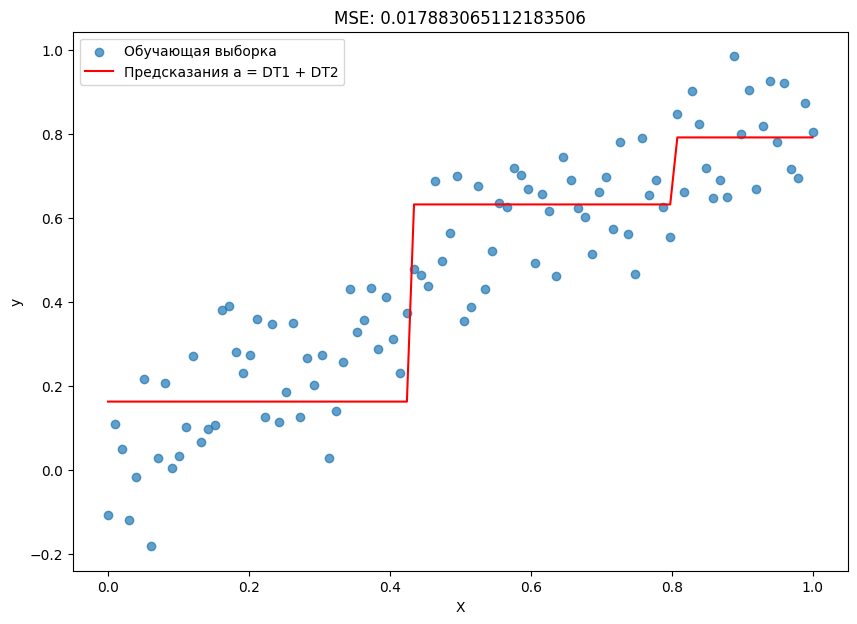

In [35]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

**Шаг 3 и далее.** Далее нам нужно обучить базовую модель, предсказывающую $s_i$. Но так как $s_i$ совпадают с остатками, этот и дальнейшие шаги будут совпадать с примером 1.1.

### 3. Функции потерь градиентного бустинга для регрессии и классификации

#### 3.1 Регрессия.

В задачах регрессии в качестве целевой функции для композиции обычно берутся:

1. $MSE$, которую мы рассматривали ранее.

2. $MAE$:

$$
MAE(y, p) = \dfrac{1}{\ell} \sum_{i = 1}^{\ell} |y_i - p_i|
$$

Попробуем сделать шаг градиентного бустинга, используя в качестве функции потерь $MAE$.

**Задание:** рассчитайте $s_i$ для $MAE$.

**Решение:** $s_i^{(N)} = -\mathrm{sign}(a^{(N-1)}(x_i) - y_i)$.

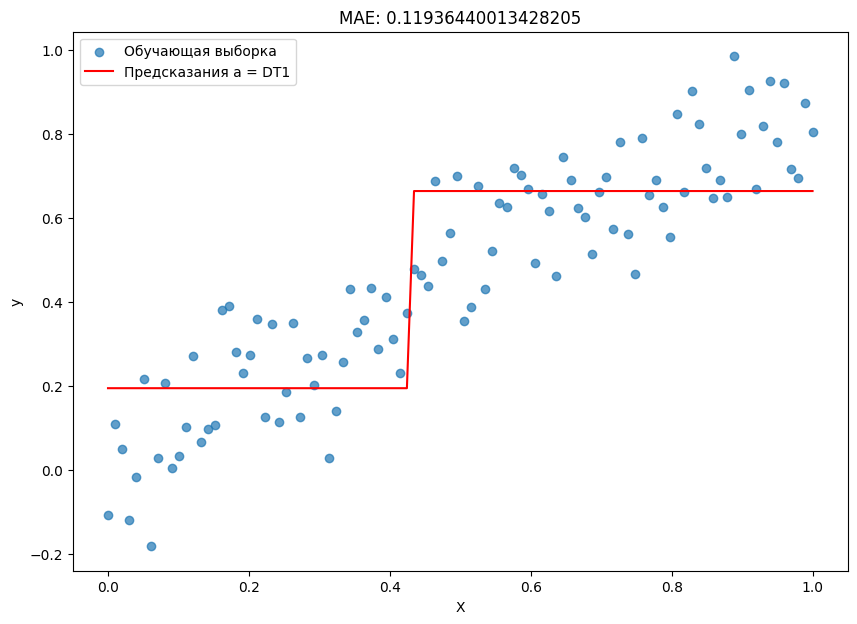

In [36]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [37]:
# TODO: рассчитайте антиградиент  
s1 = -np.sign(a - y)

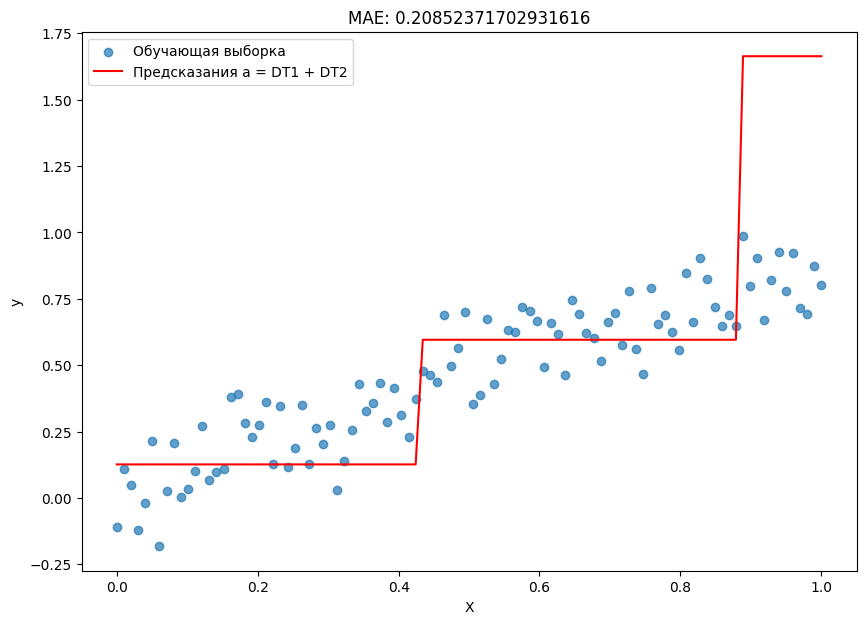

In [38]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

Заметим, что $MAE$ увеличилась, а решающая поверхность имеет "виток", уходящий за пределы обучающей выборки. Эту проблему мы решим позже.

#### 3.2 Классификация.

В задачах бинарной классификации обычно используется логистическая функция потерь, с которой мы уже сталкивались в логистической регрессии.

$$
L(y, p) = \log(1 + e^{-yp}).
$$

**Бонусное задание:** покажите, что в этом случае антиградиенты можно вычислить по формуле

$$
s^{(N)}_i = \dfrac{y_i}{1 + e^{y_ia^{(N-1)}(x_i)}}
$$

Попробуем сделать шаг градиентного бустинга в задаче бинарной классификации с логистической функцией потерь.

In [39]:
from sklearn.datasets import load_iris

# Загрузка данных
data = load_iris()
X = data['data']
y = data['target']

# Перекодируем в задачу бинарной классификации
y[y == 2] = 1
set(y)

{0, 1}

In [40]:
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [41]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

In [42]:
def log_loss(y, y_pred):
    # TODO: реализуйте логистическую функцию потерь
    return np.log(1 + np.exp(- y * y_pred)).mean()

In [43]:
# Вычисление ошибки для одного дерева
log_loss(y, a)

0.439890185198797

In [44]:
# TODO: рассчитайте антиградиент  
s1 = y / (1 + np.exp(y * a))

In [45]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

In [46]:
# Вычисление ошибки для двух деревьев
log_loss(y, a)

0.39621023915529535

### 4. Особенности градиентного бустинга

#### 4.1 Построение композиции.

В примерах выше мы строили композицию моделей простым суммированием. Понятно, что в общем виде можно строить взвешенную сумму базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} w_nb_n(X),
$$

где коэффициенты $w_n$ можно подобрать, например, при помощи градиентного спуска в задаче 

$$
w_n = \arg\min_{w} \sum_{i = 1}^{\ell} L(y_i, a^{(N-1)}(x_i) + w \times b_N(x_i)),
$$

что имеет смысл, так как $b_N(x_i)$ уже обучена и фиксирована.

**Замечание:** длина шага является одним из ключевых параметров градиентного бустинга, и может очень сильно повлиять на его производительность. Подробнее об этом [здесь](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/).

В нашем случае подбор правильного коэффициента поможет решить увеличение MAE в примере 3.1. 

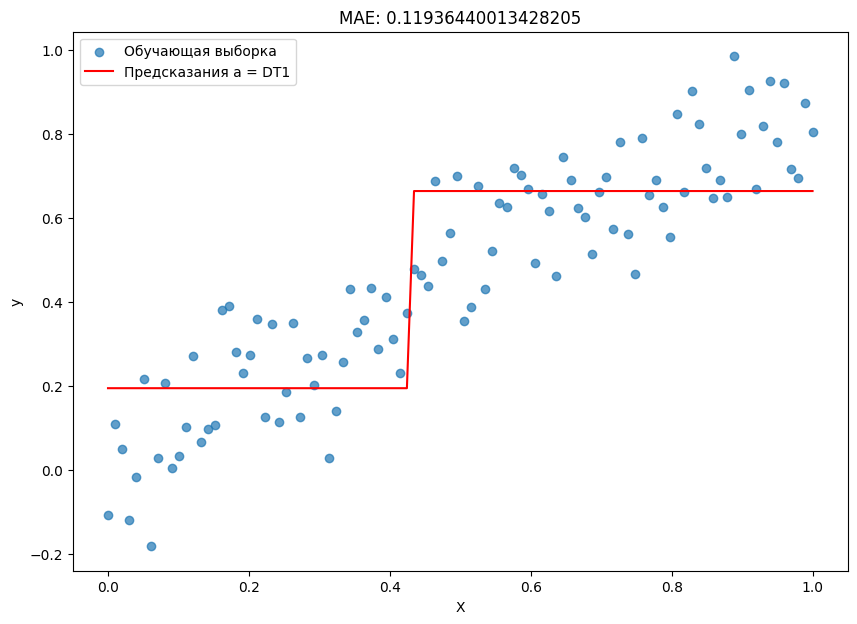

In [47]:
# Инициализация
np.random.seed(123)
N = 100
X = np.linspace(0, 1, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [48]:
# Вычисление антиградиента 
s1 = -np.sign(a - y)

In [49]:
# TODO: подберите (угадайте) вес так, чтобы уменьшить MAE
w = 0.1

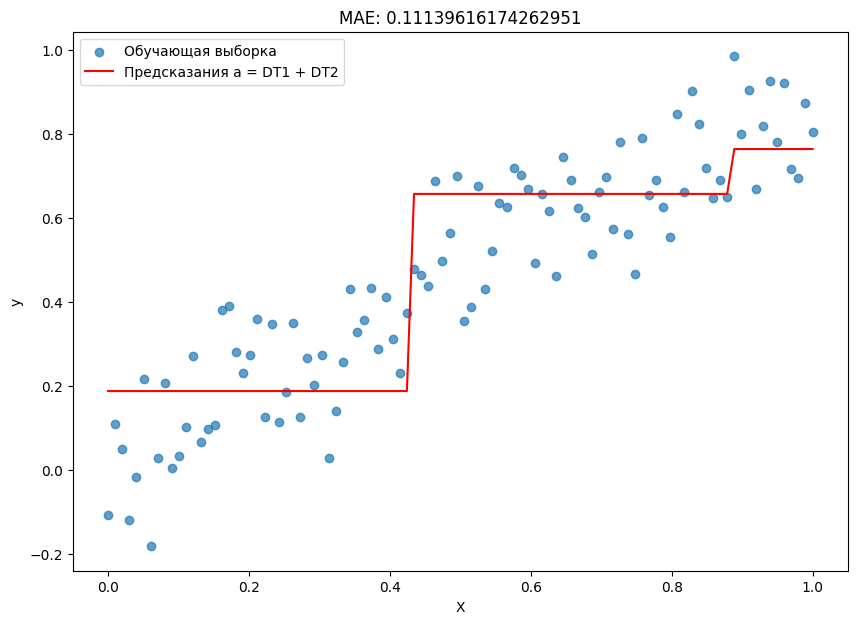

In [50]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += w * dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

#### 4.2 Переобучение.

Вспомним, что в случае бэггинга увеличение числа базовых моделей не приводило к переобучению. Например, в случайном лесе ошибки на тренировочной и тестовой выборках выходили на плато, начиная с какого-то числа деревьев. Понятно, что бустинг не будет обладать этим свойством *по построению*: при добавлении новых базовых моделей композиция всё точнее будет приближать обучающую выборку, что в конечном итоге (зачастую быстро) может привести к переобучению. Из этого можно сделать вывод, что в случае бустинга ошибка на обучающей выборке в зависимости от числа деревьев является убывающей функцией, а ошибка на тестовой выборке, скорее всего, имеет U-образный вид. Убедимся в этом и сравним поведение ошибок и решающих поверхностей бустинга и случайного леса. 

Здесь и далее будем использовать [реализацию бустинга](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из `sklearn`, которая представляет собой градиентный бустинг над деревьями.

In [51]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [52]:
# Генерация выборки
np.random.seed(123)
X = np.linspace(0, 1, 300).reshape(-1, 1)

def target(a):
    return a > 0.5

y = target(X) + np.random.normal(size = X.shape) * 0.1
y = y[:, 0]

In [53]:
X

array([[0.        ],
       [0.00334448],
       [0.00668896],
       [0.01003344],
       [0.01337793],
       [0.01672241],
       [0.02006689],
       [0.02341137],
       [0.02675585],
       [0.03010033],
       [0.03344482],
       [0.0367893 ],
       [0.04013378],
       [0.04347826],
       [0.04682274],
       [0.05016722],
       [0.05351171],
       [0.05685619],
       [0.06020067],
       [0.06354515],
       [0.06688963],
       [0.07023411],
       [0.0735786 ],
       [0.07692308],
       [0.08026756],
       [0.08361204],
       [0.08695652],
       [0.090301  ],
       [0.09364548],
       [0.09698997],
       [0.10033445],
       [0.10367893],
       [0.10702341],
       [0.11036789],
       [0.11371237],
       [0.11705686],
       [0.12040134],
       [0.12374582],
       [0.1270903 ],
       [0.13043478],
       [0.13377926],
       [0.13712375],
       [0.14046823],
       [0.14381271],
       [0.14715719],
       [0.15050167],
       [0.15384615],
       [0.157

In [54]:
y

array([-1.08563060e-01,  9.97345447e-02,  2.82978498e-02, -1.50629471e-01,
       -5.78600252e-02,  1.65143654e-01, -2.42667924e-01, -4.28912629e-02,
        1.26593626e-01, -8.66740402e-02, -6.78886152e-02, -9.47089689e-03,
        1.49138963e-01, -6.38901997e-02, -4.43981960e-02, -4.34351276e-02,
        2.20593008e-01,  2.18678609e-01,  1.00405390e-01,  3.86186399e-02,
        7.37368576e-02,  1.49073203e-01, -9.35833868e-02,  1.17582904e-01,
       -1.25388067e-01, -6.37751502e-02,  9.07105196e-02, -1.42868070e-01,
       -1.40068720e-02, -8.61754896e-02, -2.55619371e-02, -2.79858911e-01,
       -1.77153310e-01, -6.99877235e-02,  9.27462432e-02, -1.73635683e-02,
        2.84591590e-04,  6.88222711e-02, -8.79536343e-02,  2.83627324e-02,
       -8.05366518e-02, -1.72766949e-01, -3.90899794e-02,  5.73805862e-02,
        3.38589051e-02, -1.18304945e-03,  2.39236527e-01,  4.12912160e-02,
        9.78736006e-02,  2.23814334e-01, -1.29408532e-01, -1.03878821e-01,
        1.74371223e-01, -

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

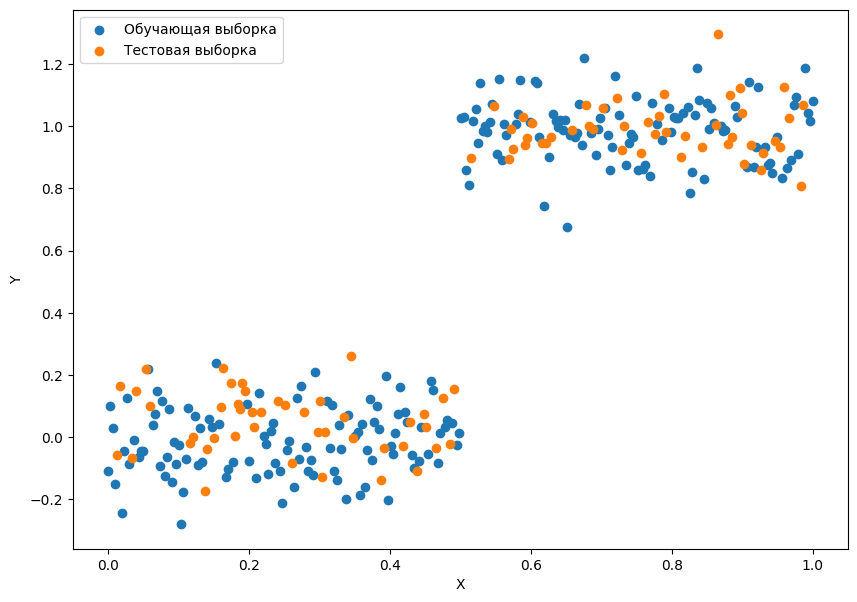

In [56]:
# Визуализация выборки
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, label = 'Тестовая выборка')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

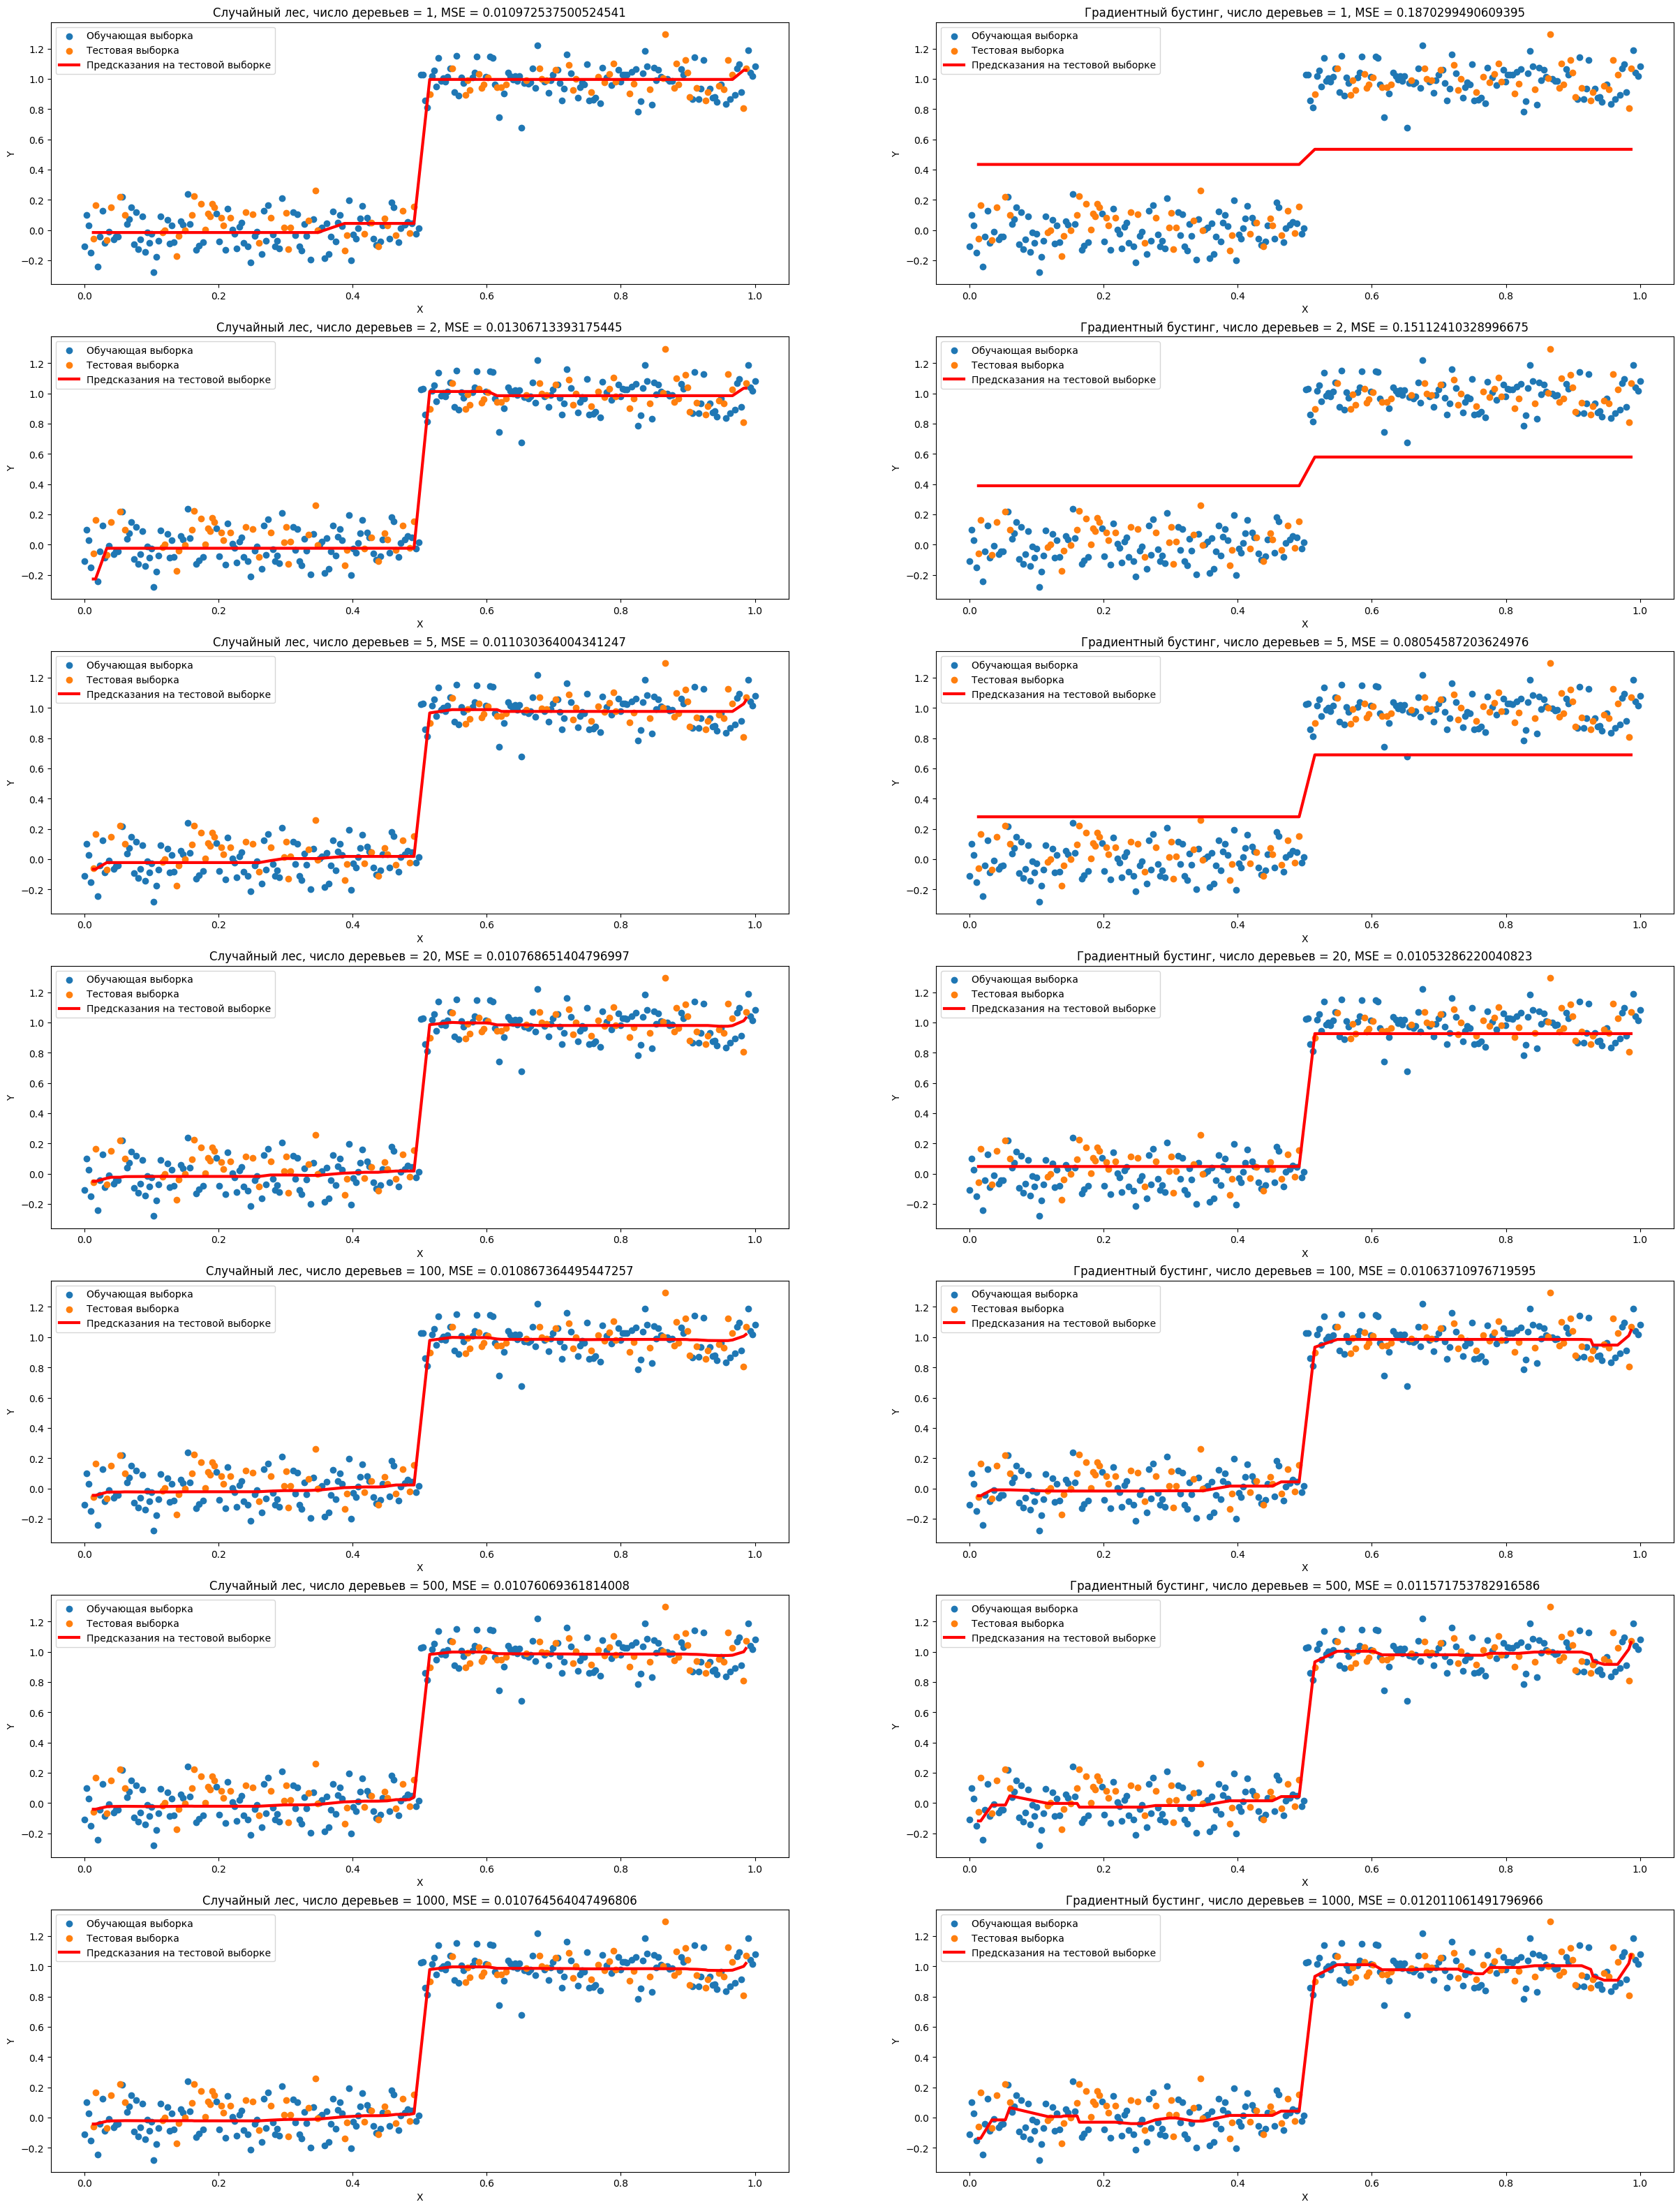

In [57]:
# Визуализация решающих поверхностей
trees = [1, 2, 5, 20, 100, 500, 1000]

fig, ax = plt.subplots(len(trees), 2, figsize = (30, 40))

loss_rf_train = []
loss_gb_train = []
loss_rf_test = []
loss_gb_test = []

for i, ts in enumerate(trees):
    rf = RandomForestRegressor(n_estimators = ts, max_depth = 2)
    gb = GradientBoostingRegressor(n_estimators = ts, max_depth = 1, learning_rate = 0.1)
    
    rf.fit(X_train, y_train)
    ax[i, 0].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 0].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 0].plot(sorted(X_test), rf.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 0].set_xlabel('X')
    ax[i, 0].set_ylabel('Y')
    ax[i, 0].set_title('Случайный лес, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, rf.predict(X_test))))
    ax[i, 0].legend();
    
    loss_rf_train.append(mean_squared_error(y_train, rf.predict(X_train)))
    loss_rf_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    
    gb.fit(X_train, y_train)
    ax[i, 1].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 1].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 1].plot(sorted(X_test), gb.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 1].set_xlabel('X')
    ax[i, 1].set_ylabel('Y')
    ax[i, 1].set_title('Градиентный бустинг, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, gb.predict(X_test))))
    ax[i, 1].legend();
    
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

Как мы видим, решающая поверхность случайного леса не изменяется при достижении определённого числа деревьев, в то время как для бустинга она становится всё более сложной.

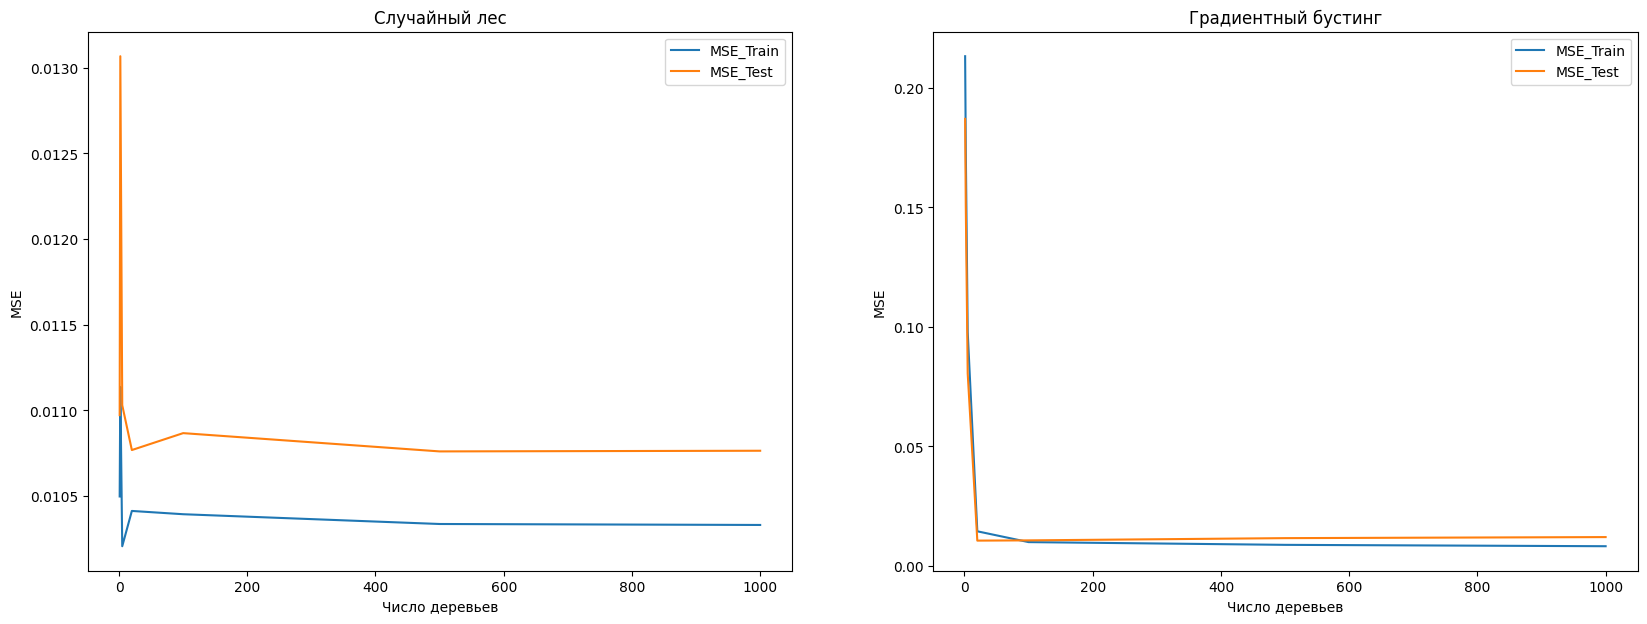

In [58]:
# Визуализация ошибок
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

ax[0].plot(trees, loss_rf_train, label = 'MSE_Train')
ax[0].plot(trees, loss_rf_test, label = 'MSE_Test')
ax[0].set_xlabel('Число деревьев')
ax[0].set_ylabel('MSE')
ax[0].set_title('Случайный лес')
ax[0].legend()

ax[1].plot(trees, loss_gb_train, label = 'MSE_Train')
ax[1].plot(trees, loss_gb_test, label = 'MSE_Test')
ax[1].set_xlabel('Число деревьев')
ax[1].set_ylabel('MSE')
ax[1].set_title('Градиентный бустинг')
ax[1].legend();

Поведение ошибок для случайного леса совпадает с тем, которое мы видели на предыдущем семинаре. В случае бустинга ошибка на тренировочной выборке стабильно убывает, а на тестовой – возрастает, что вероятно говорит об (очень быстром) переобучении. Если же мы аккуратно подберём гиперпараметры для деревьев и длину шага, то сможем добиться типичной U-образной формы функции потерь на тестовой выборке.

В качестве способа регуляризации также может использоваться сокращение шага:

$$
a^{(N)}(X) = a^{(N-1)}(X) + \alpha w_N b^{(N)}(X),
$$

где $\alpha \in (0, 1]$ – темп обучения, или стохастический градиентный бустинг.

**Важный момент:** примеры выше демонстрируют, насколько быстро бустинг может переобучаться, и как в его случае важен подбор гиперпараметров. В связи с этим может сложиться ситуация, что градиентный бустинг с дефолтными параметрами показывает более плохое качество, чем, например, случайный лес с дефолтными параметрами, однако хорошо настроенный градиентный бустинг [обычно превосходит](https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests) случайный лес по качеству. Важна и конкретная реализация бустинга: например, [здесь](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956), представлено очень хорошее сравнение различных имплементаций. 

#### 4.3 Пара слов о смещении и дисперсии.

Вспомним, что в случайном лесе в качестве базовых моделей мы брали переобученные деревья, мотивируя это тем, что бэггинг позволит сохранить низкое смещение и при этом уменьшить дисперсию. Бустинг по построению работает проивоположно: композиция обладает более низким, чем базовые модели, смещением, но такой же или большей дисперсией (ещё раз проговорите последовательность построения бустинга, и вы увидите, почему это так). Поэтому в качестве базовых моделей для бустинга обычно используются модели с высоким смещением и низкой дисперсией – как мы знаем, такие модели являются недообученными – например, неглубокие решающие деревья.

### 5. Тестирование градиентного бустинга на разных данных

На прошлом семинаре мы выяснили, что случайный лес с дефолтными гиперпараметрами превосходит другие изученные нами алгоритмы на разных типах данных. Попробуем на тех же данных сравнить случайный лес и градиентный бустинг. 

**Важное замечание:** скорее всего, бустинг с дефолтными гиперпараметрами будет показывать более плохое качество, чем случайный лес с дефолтными гиперпараметрами – ключевую роль в бустинге играет подбор гиперпараметров. В дополнение, сравнение различных имплементаций по ссылке выше показывает, что реализация `sklearn` может оказаться не самой удачной по качеству (спорный вопрос!). Поэтому попробуйте провести как можно больше экспериментов и подобрать такие гиперпараметры для бустинга, чтобы превзойти случайный лес по качеству.

**Внимание:** в этой части вам предстоит скачивать объёмные наборы данных. Не забудьте удалить их после семинара, если не планируете использовать их в дальнейшем, чтобы они не занимали лишнее место на вашем компьютере.

**! Модели могут обучаться очень-очень долго.**

#### 5.1 Бинарная классификация на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

In [59]:
# Загрузка данных
!wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [60]:
data = pd.read_csv('kaggle_response.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score

# TODO: обучите градиентный бустинг и случайный лес с дефолтными параметрами
# Сравните их AUC ROC на тестовой выборке
# gb = GradientBoostingClassifier()
# gb.fit(X_train, y_train)
# pred_gb = gb.predict_proba(X_test)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)

# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству
gb = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 10, loss = 'exponential')
gb.fit(X_train, y_train)
pred_gb = gb.predict_proba(X_test)

In [62]:
roc_auc_score(y_test, pred_gb[:, 1])

0.878112204674347

In [63]:
roc_auc_score(y_test, pred_rf[:, 1])

0.875524528877699

#### 5.2 Изображения на примере [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [147]:
# Загрузка данных
import torchvision

fmnist = torchvision.datasets.FashionMNIST('./', download = True)
X = fmnist.data.numpy().reshape(-1, 28 * 28)
y = fmnist.targets.numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [ ]:
from sklearn.metrics import accuracy_score

# TODO: обучите градиентный бустинг и случайный лес с дефолтными параметрами
# Сравните их доли правильных ответов на тестовой выборке
gb = GradientBoostingClassifier(max_depth = 1, n_estimators = 100)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

rf = RandomForestClassifier(n_estimators = 10, max_depth = 100)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству


In [ ]:
accuracy_score(y_test, pred_gb)

In [ ]:
accuracy_score(y_test, pred_rf)

#### 5.3 Тексты на примере бинарной классификации твитов 

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler

# Предобработка из семинара 10
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = 'positive'
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = 'negative'
df = pd.concat([positive, negative])

X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state=13)

vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

X_train = bow
X_test = bow_test

In [85]:
# TODO: обучите градиентный бустинг с дефолтными параметрами
# и случайный лес с числом деревьев 100 и макс. глубиной дерева 20 
# Сравните их доли правильных ответов на тестовой выборке

gb = GradientBoostingClassifier(max_depth = 1, n_estimators = 20)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

rf = RandomForestClassifier(n_estimators = 20, max_depth = 20)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# TODO: попробуйте настроить градиентный бустинг так, чтобы превзойти случайный лес по качеству



In [86]:
accuracy_score(y_test, pred_gb)

0.5812304925144157

In [87]:
accuracy_score(y_test, pred_rf)

0.6245745825177661

## Part II (at home)

!["История"](bst.png)

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [88]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plot', 'negative', 'positive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Будем решать задачу классификации: по различным характеристикам клиента попытаемся определить, выплатит клиент долг или нет.

In [89]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
len(X_train), len(X_test)

(24365, 10443)

In [90]:
X_train.head()

Existing_EMI  Loan_Amount_Applied  Loan_Tenure_Applied  Monthly_Income  \
0           0.0             250000.0                  5.0           23200   
1           0.0                  0.0                  0.0           25000   
2           0.0                  0.0                  0.0           95000   
3           0.0                  0.0                  0.0           29880   
4        4500.0             100000.0                  3.0           30000   

   Var4  Var5  Age  EMI_Loan_Submitted_Missing  Interest_Rate_Missing  \
0     2     3   28                           1                      1   
1     0     0   33                           1                      1   
2     3     7   39                           1                      1   
3     5     3   28                           0                      0   
4     5    10   26                           0                      0   

   Loan_Amount_Submitted_Missing  ...  Var2_4  Var2_5  Var2_6  \
0                              0  ...       0       0       0   
1                              1  ...       0       0       1   
2                              0  ...       0       0       1   
3                              0  ...       0       0       0   
4                              0  ...       0       0       1   

   Mobile_Verified_0  Mobile_Verified_1  Source_0  Source_1  Source_2  \
0                  0                  1         0         1         0   
1                  0                  1         1         0         0   
2                  0                  1         1         0         0   
3                  0                  1         0         1         0   
4                  0                  1         1         0         0   

   Disbursed     ID  
0        0.0   8161  
1        0.0  77530  
2        0.0  80633  
3        0.0  45059  
4        0.0  54857  

[5 rows x 51 columns]

Для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры. 

Алгоритм подбора гиперпараметров следующий:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [91]:
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [92]:
target='Disbursed'
IDcol = 'ID'

In [93]:
X_train['Disbursed'].value_counts(), len(X_train)

(Disbursed
 0.0    23999
 1.0      366
 Name: count, dtype: int64,
 24365)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance 

In [94]:
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Начинаем последовательный подбор параметров при большом learning_rate

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.985
AUC Score (Train): 0.931461
AUC Score (Test): 0.829855


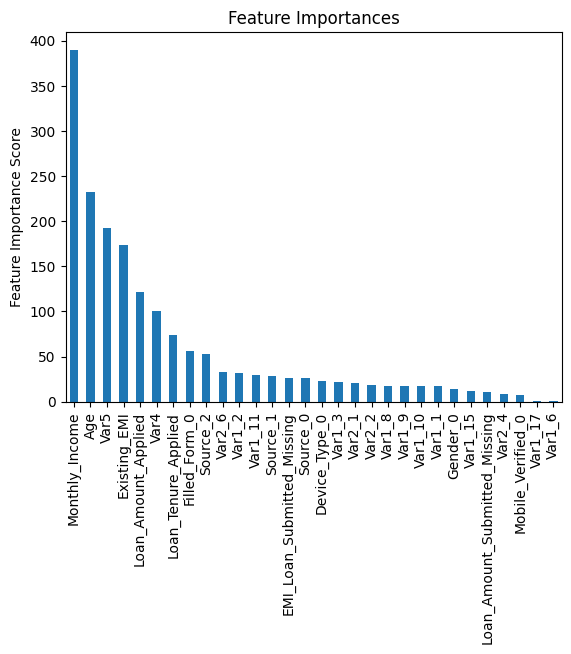

In [95]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [96]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train[predictors],X_train[target])

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 5}, 0.8274289090608191)

Уточняем предсказание

In [97]:
param_test2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3, 4]
}

gsearch2 = GridSearchCV(estimator=model_xgb, 
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train[predictors],X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.828948217260183)

Зафиксируем найденный max_depth и min_child_weight

In [98]:
model_xgb.max_depth = 5
model_xgb.min_child_weight = 3

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

### your code

In [ ]:
param_test3 = {
    'gamma': # your code here
}

gsearch3b = # your code here

gsearch3b.fit(X_train[predictors],X_train[target])

In [ ]:
gsearch3b.best_params_, gsearch3b.best_score_

Установите в качестве параметра алгоритма подобранyю gamma и посмотрите как изменилось качество.

In [ ]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [ ]:
# your code here

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [ ]:
# your code here

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.

In [ ]:
# your code here

modelfit(model_xgb, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.

In [ ]:
#Your code here

modelfit(model_xgb, X_train, X_test, predictors)

## 2. CatBoost

Оригинальный ноутбук здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг 

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [ ]:
#!pip install --upgrade catboost
#!pip install --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
#!jupyter nbextension enable --py widgetsnbextension

In [99]:
from matplotlib import pylab as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [100]:
import pandas as pd
import os
import numpy as np

In [101]:
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [102]:
train_df = pd.read_csv('./amazon/train.csv')
train_df.head()

ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

In [103]:
test_df = pd.read_csv('./amazon/test.csv')
test_df.head()

id  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0   1     78766   72734         118079         118080         117878   
1   2     40644    4378         117961         118327         118507   
2   3     75443    2395         117961         118300         119488   
3   4     43219   19986         117961         118225         118403   
4   5     42093   50015         117961         118343         119598   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117879            118177        19721     117880  
1      118863            122008       118398     118865  
2      118172            301534       249618     118175  
3      120773            136187       118960     120774  
4      118422            300136       118424     118425

Готовим данные

In [104]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Создаем список категориальных фичей

In [105]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [106]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Способы создать Pool - объект, содержащий матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [107]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3: ' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [109]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Печать результатов

In [110]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 3.94ms	remaining: 35.5ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 8.24ms	remaining: 33ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 10.4ms	remaining: 24.2ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 13.3ms	remaining: 19.9ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 16.3ms	remaining: 16.3ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 19ms	remaining: 12.7ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 20.6ms	remaining: 8.83ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 22.2ms	remaining: 5.56ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 23.3ms	remaining: 2.59ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 24.6ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Визуализация метрик

In [111]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [112]:
model1 = CatBoostClassifier(
    learning_rate=0.1,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.1'
)

model2 = CatBoostClassifier(
    learning_rate=0.07,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.07'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost import MetricVisualizer

MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

Оптимальное количество деревьев

In [114]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [115]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 92


Кросс-валидация

In [116]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1674879003
bestIteration = 36

Training on fold [1/5]

bestTest = 0.1642588398
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1531042161
bestIteration = 63

Training on fold [3/5]

bestTest = 0.1426916182
bestIteration = 78

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [117]:
cv_data.head()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.302367          0.004317            0.302196   
1           1           0.226879          0.007618            0.228406   
2           2           0.189560          0.005706            0.195723   
3           3           0.178061          0.006784            0.186107   
4           4           0.171654          0.007401            0.181249   

   train-Logloss-std  test-AUC-mean  test-AUC-std  
0           0.004517       0.513577      0.030360  
1           0.005219       0.640026      0.046937  
2           0.004473       0.797855      0.011978  
3           0.003632       0.815144      0.010133  
4           0.002254       0.827182      0.004918

In [118]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation LogLoss score, not stratified: 0.1574±0.0094 on step 62


Детектор переобучения

In [119]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [120]:
print(model_with_early_stop.tree_count_)

21


In [121]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [122]:
print(model_with_early_stop.tree_count_)

52


Вычисление метрик качества и выбор порога принятия решения

In [123]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [124]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

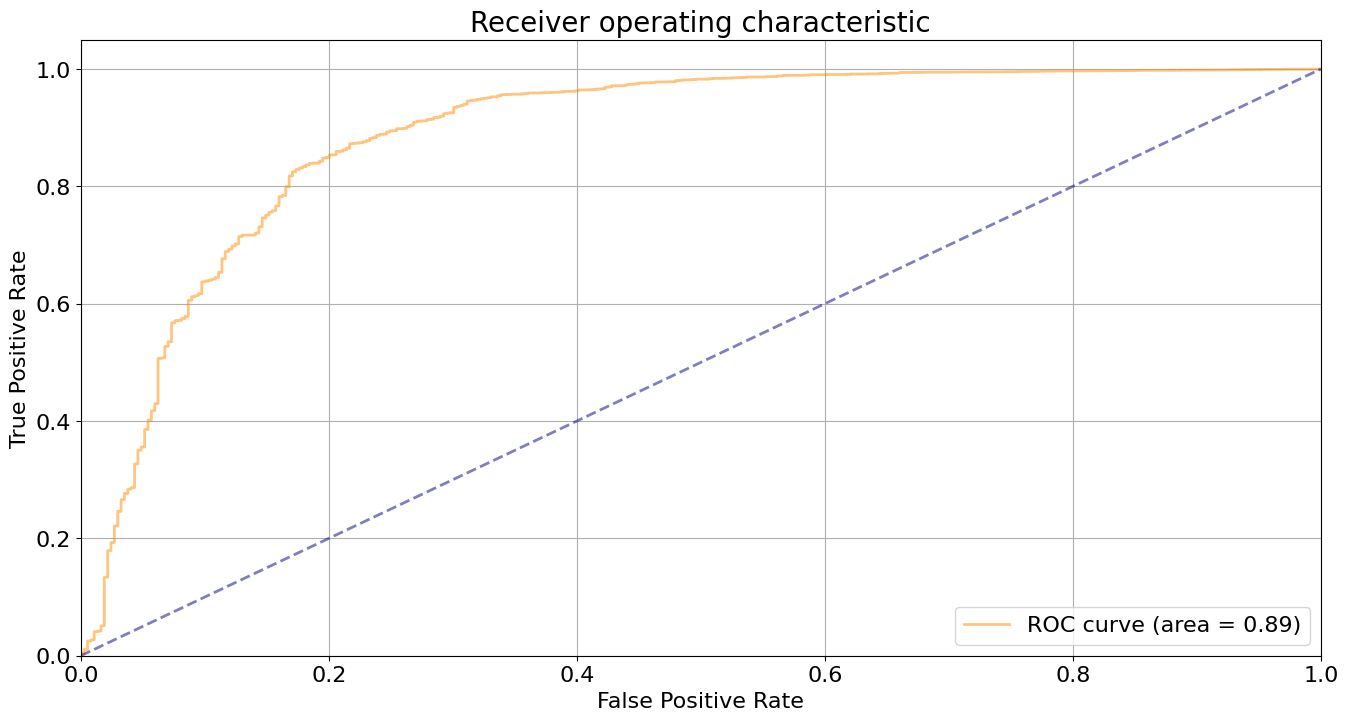

In [125]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [126]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

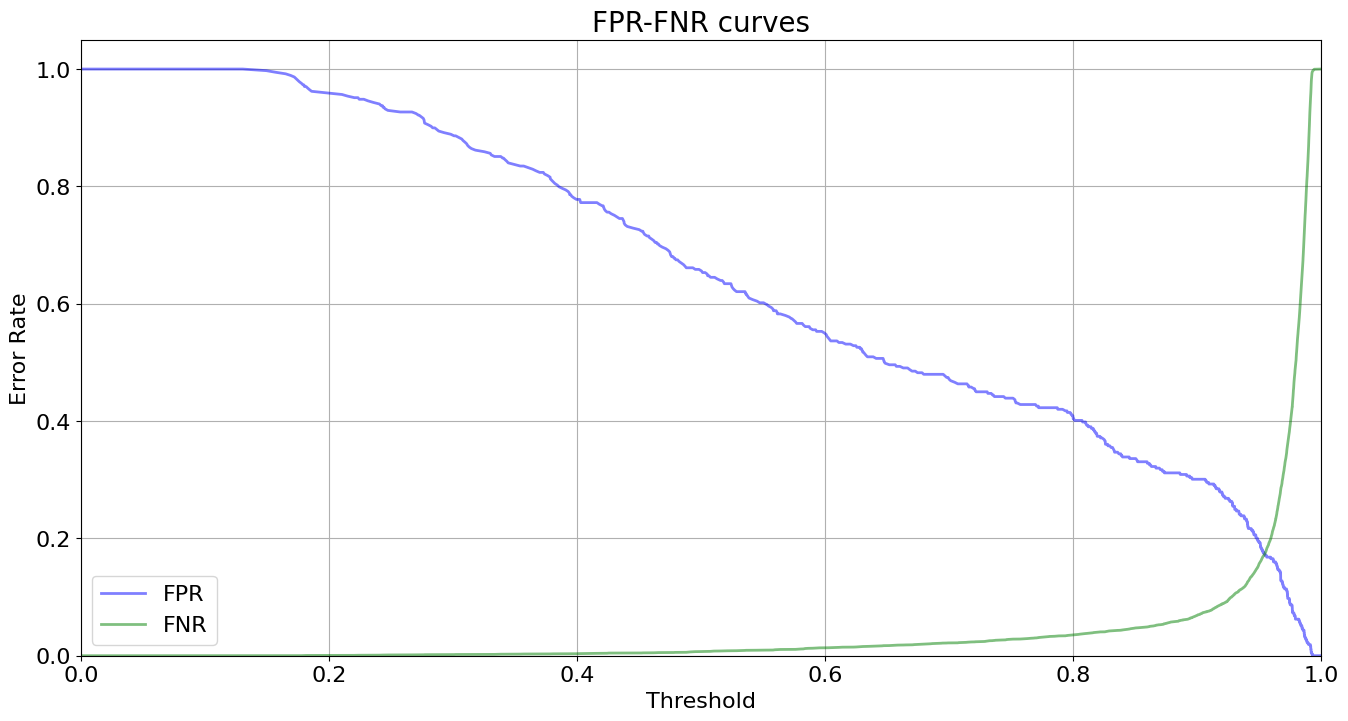

In [127]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [128]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.5589790557061969
0.9922433395240446


Получение предсказаний

In [129]:
print(model.predict_proba(X_validation))

[[0.01138691 0.98861309]
 [0.01851115 0.98148885]
 [0.01690687 0.98309313]
 ...
 [0.01194976 0.98805024]
 [0.00881882 0.99118118]
 [0.01390561 0.98609439]]


In [130]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


Последовательные предсказания

In [131]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4794317 0.5205683]
 [0.4794317 0.5205683]
 [0.4794317 0.5205683]
 ...
 [0.4794317 0.5205683]
 [0.4794317 0.5205683]
 [0.4794317 0.5205683]]
Iteration 1, predictions:
[[0.45881832 0.54118168]
 [0.45881832 0.54118168]
 [0.45881832 0.54118168]
 ...
 [0.45881832 0.54118168]
 [0.45881832 0.54118168]
 [0.45881832 0.54118168]]
Iteration 2, predictions:
[[0.43966701 0.56033299]
 [0.43966701 0.56033299]
 [0.43966701 0.56033299]
 ...
 [0.43966701 0.56033299]
 [0.43966701 0.56033299]
 [0.43966701 0.56033299]]
Iteration 3, predictions:
[[0.41842459 0.58157541]
 [0.41842459 0.58157541]
 [0.42593459 0.57406541]
 ...
 [0.41842459 0.58157541]
 [0.41842459 0.58157541]
 [0.41842459 0.58157541]]
Iteration 4, predictions:
[[0.40040568 0.59959432]
 [0.40040568 0.59959432]
 [0.40781905 0.59218095]
 ...
 [0.40040568 0.59959432]
 [0.40040568 0.59959432]
 [0.40040568 0.59959432]]


Важность признаков

In [132]:
model.get_feature_importance(prettified=True)

Feature Id  Importances
0            MGR_ID    23.457070
1          RESOURCE    20.515127
2     ROLE_DEPTNAME    14.267019
3  ROLE_FAMILY_DESC    10.310366
4     ROLE_ROLLUP_2     9.972613
5         ROLE_CODE     7.810630
6        ROLE_TITLE     5.366066
7       ROLE_FAMILY     4.576275
8     ROLE_ROLLUP_1     3.724834

### Shap values 

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [133]:
import shap

shap_values = model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(32769, 9)


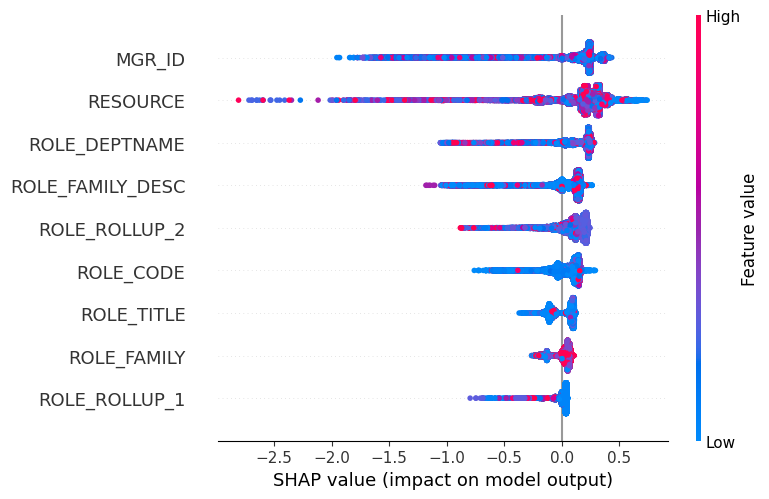

In [134]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [135]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Сохранение модели

In [136]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [137]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


Подбор гиперпараметров

In [138]:
cat = CatBoostClassifier(n_estimators=50)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6563227	test: 0.6566072	best: 0.6566072 (0)	total: 8.2ms	remaining: 402ms
1:	learn: 0.6227276	test: 0.6234014	best: 0.6234014 (1)	total: 12.1ms	remaining: 291ms
2:	learn: 0.5915535	test: 0.5927244	best: 0.5927244 (2)	total: 18.1ms	remaining: 284ms
3:	learn: 0.5626485	test: 0.5641488	best: 0.5641488 (3)	total: 25.2ms	remaining: 290ms
4:	learn: 0.5360495	test: 0.5378118	best: 0.5378118 (4)	total: 29.7ms	remaining: 267ms
5:	learn: 0.5116681	test: 0.5137107	best: 0.5137107 (5)	total: 33.6ms	remaining: 247ms
6:	learn: 0.4891786	test: 0.4914464	best: 0.4914464 (6)	total: 37.1ms	remaining: 228ms
7:	learn: 0.4684688	test: 0.4710067	best: 0.4710067 (7)	total: 41.5ms	remaining: 218ms
8:	learn: 0.4494889	test: 0.4523627	best: 0.4523627 (8)	total: 62.7ms	remaining: 286ms
9:	learn: 0.4317230	test: 0.4348204	best: 0.4348204 (9)	total: 66.5ms	remaining: 266ms
10:	learn: 0.4155908	test: 0.4189671	best: 0.4189671 (10)	total: 70.2ms	remaining: 249ms
11:	learn: 0.4007153	test: 0.4044185	best:

26:	learn: 0.2726275	test: 0.2799653	best: 0.2799653 (26)	total: 136ms	remaining: 116ms
27:	learn: 0.2683531	test: 0.2759072	best: 0.2759072 (27)	total: 144ms	remaining: 113ms
28:	learn: 0.2645692	test: 0.2722761	best: 0.2722761 (28)	total: 149ms	remaining: 108ms
29:	learn: 0.2610037	test: 0.2688965	best: 0.2688965 (29)	total: 159ms	remaining: 106ms
30:	learn: 0.2573150	test: 0.2653297	best: 0.2653297 (30)	total: 165ms	remaining: 101ms
31:	learn: 0.2540651	test: 0.2622571	best: 0.2622571 (31)	total: 180ms	remaining: 101ms
32:	learn: 0.2510765	test: 0.2593908	best: 0.2593908 (32)	total: 190ms	remaining: 97.9ms
33:	learn: 0.2481548	test: 0.2566115	best: 0.2566115 (33)	total: 197ms	remaining: 92.9ms
34:	learn: 0.2456040	test: 0.2542082	best: 0.2542082 (34)	total: 206ms	remaining: 88.1ms
35:	learn: 0.2431480	test: 0.2518967	best: 0.2518967 (35)	total: 212ms	remaining: 82.6ms
36:	learn: 0.2410683	test: 0.2499431	best: 0.2499431 (36)	total: 219ms	remaining: 76.9ms
37:	learn: 0.2388316	test: 

20:	learn: 0.2977556	test: 0.3062349	best: 0.3062349 (20)	total: 264ms	remaining: 365ms
21:	learn: 0.2903969	test: 0.2991900	best: 0.2991900 (21)	total: 278ms	remaining: 354ms
22:	learn: 0.2838924	test: 0.2930688	best: 0.2930688 (22)	total: 292ms	remaining: 343ms
23:	learn: 0.2776152	test: 0.2870029	best: 0.2870029 (23)	total: 304ms	remaining: 329ms
24:	learn: 0.2718704	test: 0.2816294	best: 0.2816294 (24)	total: 315ms	remaining: 315ms
25:	learn: 0.2664652	test: 0.2766274	best: 0.2766274 (25)	total: 327ms	remaining: 302ms
26:	learn: 0.2619019	test: 0.2722453	best: 0.2722453 (26)	total: 338ms	remaining: 288ms
27:	learn: 0.2575098	test: 0.2681832	best: 0.2681832 (27)	total: 349ms	remaining: 274ms
28:	learn: 0.2537896	test: 0.2646515	best: 0.2646515 (28)	total: 359ms	remaining: 260ms
29:	learn: 0.2500185	test: 0.2611700	best: 0.2611700 (29)	total: 370ms	remaining: 247ms
30:	learn: 0.2470575	test: 0.2583587	best: 0.2583587 (30)	total: 373ms	remaining: 229ms
31:	learn: 0.2438811	test: 0.255

26:	learn: 0.1761556	test: 0.1987571	best: 0.1987571 (26)	total: 319ms	remaining: 271ms
27:	learn: 0.1747432	test: 0.1979627	best: 0.1979627 (27)	total: 330ms	remaining: 259ms
28:	learn: 0.1725317	test: 0.1972756	best: 0.1972756 (28)	total: 346ms	remaining: 251ms
29:	learn: 0.1708144	test: 0.1962777	best: 0.1962777 (29)	total: 357ms	remaining: 238ms
30:	learn: 0.1693382	test: 0.1956226	best: 0.1956226 (30)	total: 367ms	remaining: 225ms
31:	learn: 0.1680817	test: 0.1954413	best: 0.1954413 (31)	total: 377ms	remaining: 212ms
32:	learn: 0.1670427	test: 0.1948913	best: 0.1948913 (32)	total: 388ms	remaining: 200ms
33:	learn: 0.1648098	test: 0.1939185	best: 0.1939185 (33)	total: 399ms	remaining: 188ms
34:	learn: 0.1628364	test: 0.1929179	best: 0.1929179 (34)	total: 410ms	remaining: 176ms
35:	learn: 0.1612455	test: 0.1921005	best: 0.1921005 (35)	total: 421ms	remaining: 164ms
36:	learn: 0.1600614	test: 0.1916311	best: 0.1916311 (36)	total: 432ms	remaining: 152ms
37:	learn: 0.1590404	test: 0.191

24:	learn: 0.1821773	test: 0.1980078	best: 0.1980078 (24)	total: 286ms	remaining: 286ms
25:	learn: 0.1804325	test: 0.1967153	best: 0.1967153 (25)	total: 297ms	remaining: 274ms
26:	learn: 0.1788802	test: 0.1962220	best: 0.1962220 (26)	total: 312ms	remaining: 266ms
27:	learn: 0.1774693	test: 0.1952441	best: 0.1952441 (27)	total: 323ms	remaining: 254ms
28:	learn: 0.1759026	test: 0.1943005	best: 0.1943005 (28)	total: 334ms	remaining: 242ms
29:	learn: 0.1747063	test: 0.1933899	best: 0.1933899 (29)	total: 344ms	remaining: 229ms
30:	learn: 0.1731675	test: 0.1926572	best: 0.1926572 (30)	total: 355ms	remaining: 217ms
31:	learn: 0.1718820	test: 0.1920541	best: 0.1920541 (31)	total: 365ms	remaining: 206ms
32:	learn: 0.1706941	test: 0.1913534	best: 0.1913534 (32)	total: 376ms	remaining: 194ms
33:	learn: 0.1696904	test: 0.1909642	best: 0.1909642 (33)	total: 387ms	remaining: 182ms
34:	learn: 0.1689368	test: 0.1902893	best: 0.1902893 (34)	total: 398ms	remaining: 170ms
35:	learn: 0.1678138	test: 0.189

In [139]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.1}

Визуализация деревьев

In [140]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [141]:
cat.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [142]:
# !conda install lightgbm --y

# For those who strugle with M1/M2 macs:
# !arch -arm64 brew install libomp

In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

import numpy as np

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=100, random_state=241)

Обучение

In [ ]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Можно задать любую (придумать свою, например) метрику качества

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Подбор гиперпараметров

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)